In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [9]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [10]:
y = data['price']

del data['price']

In [11]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [12]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

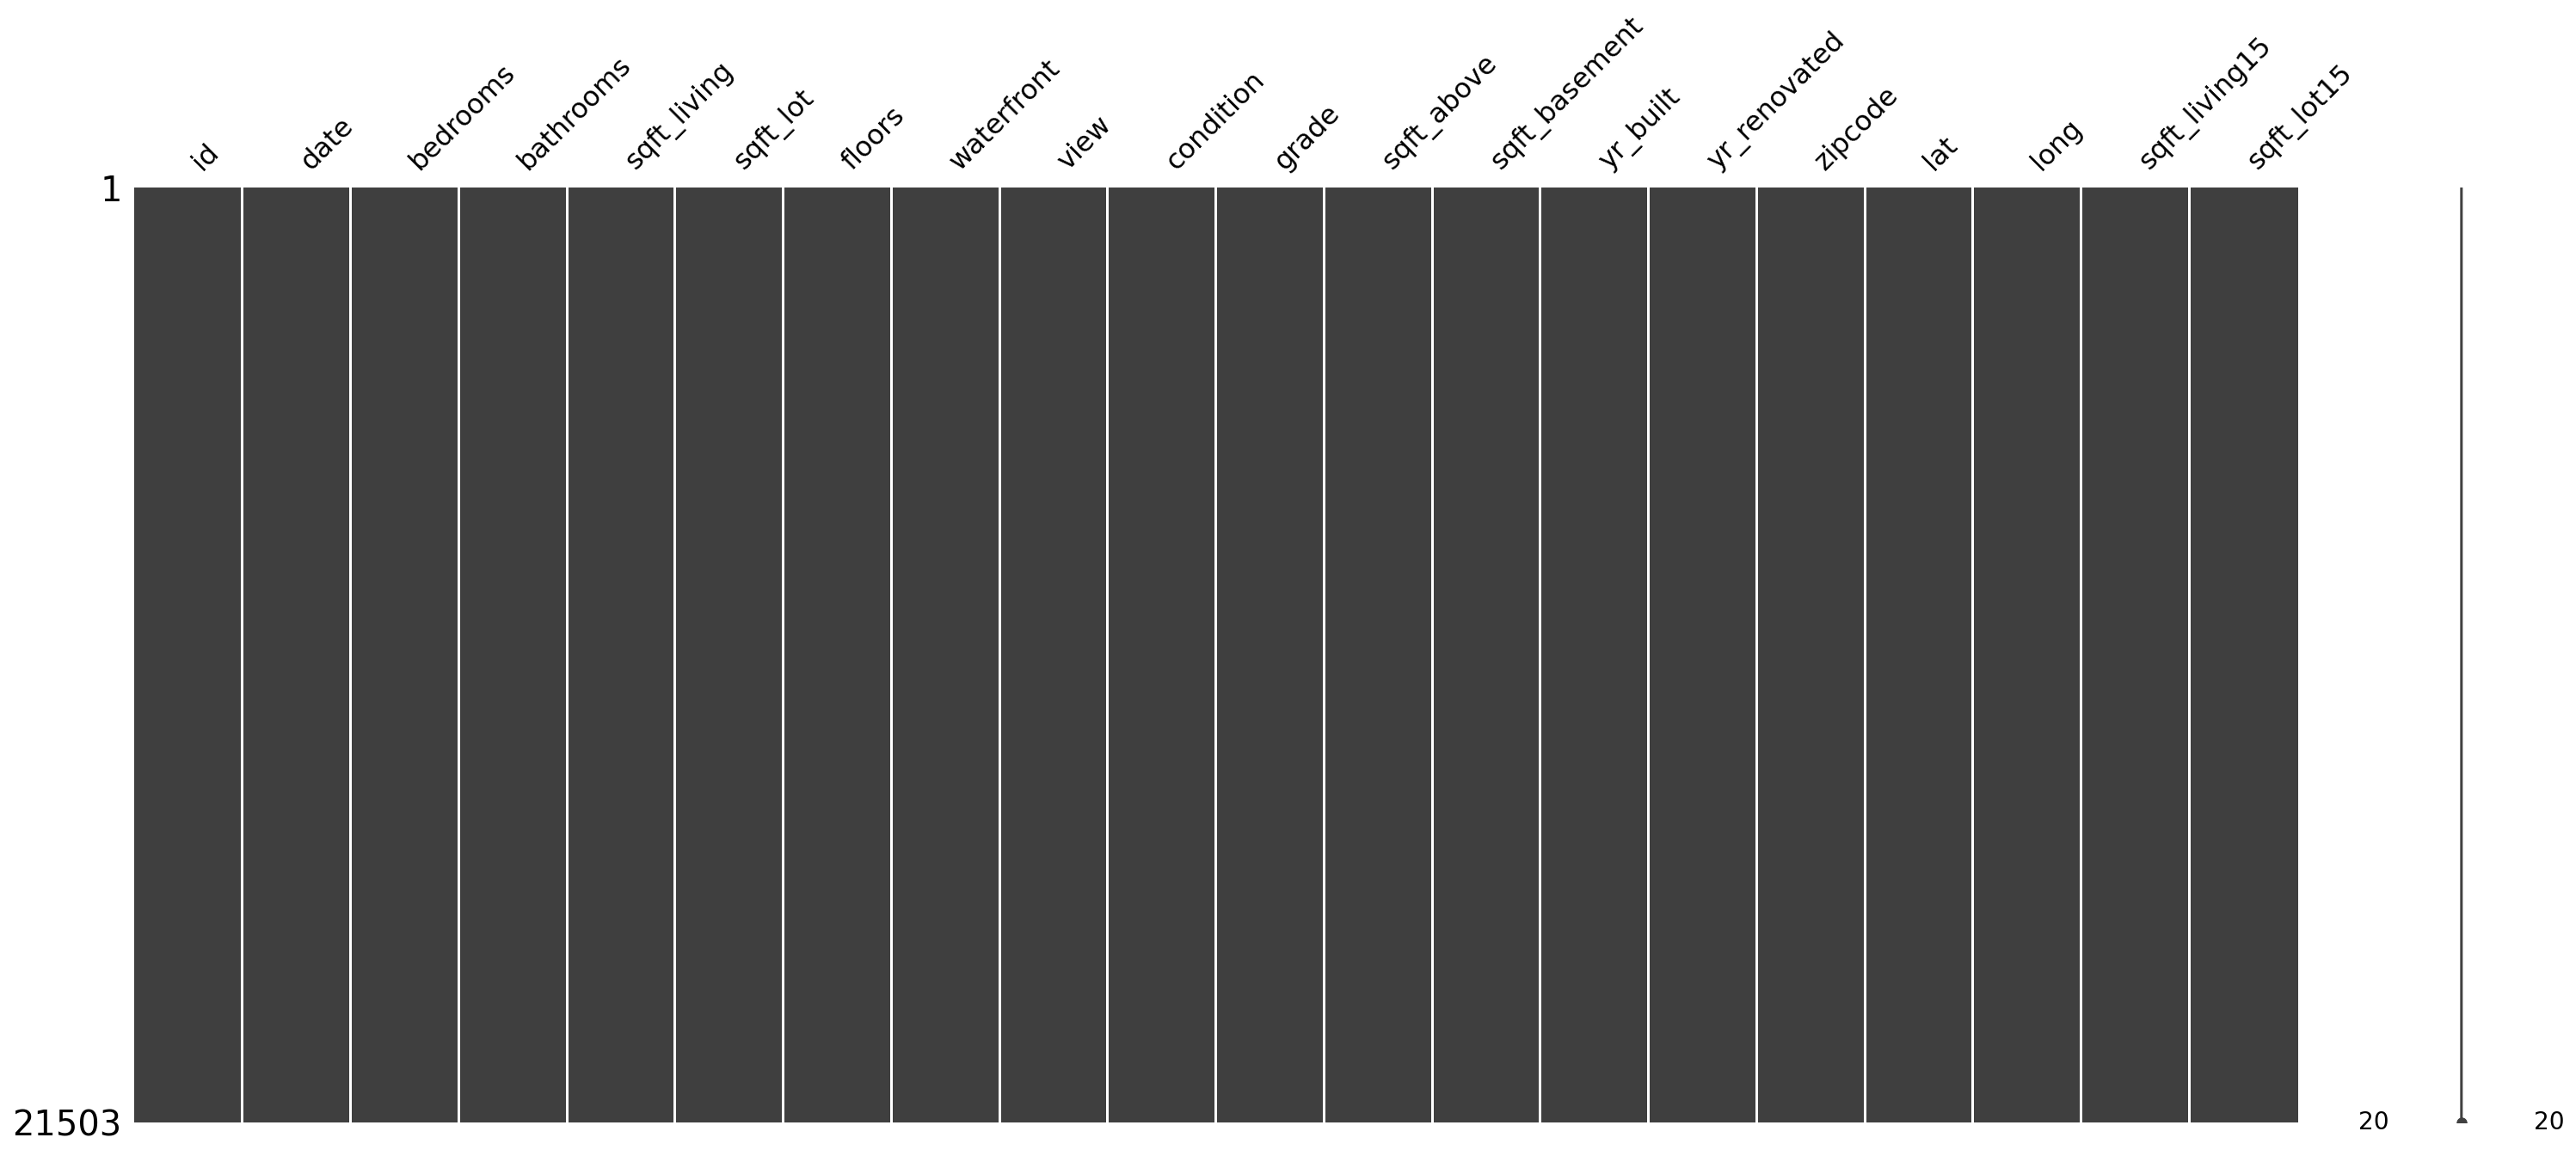

In [13]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [14]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [15]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

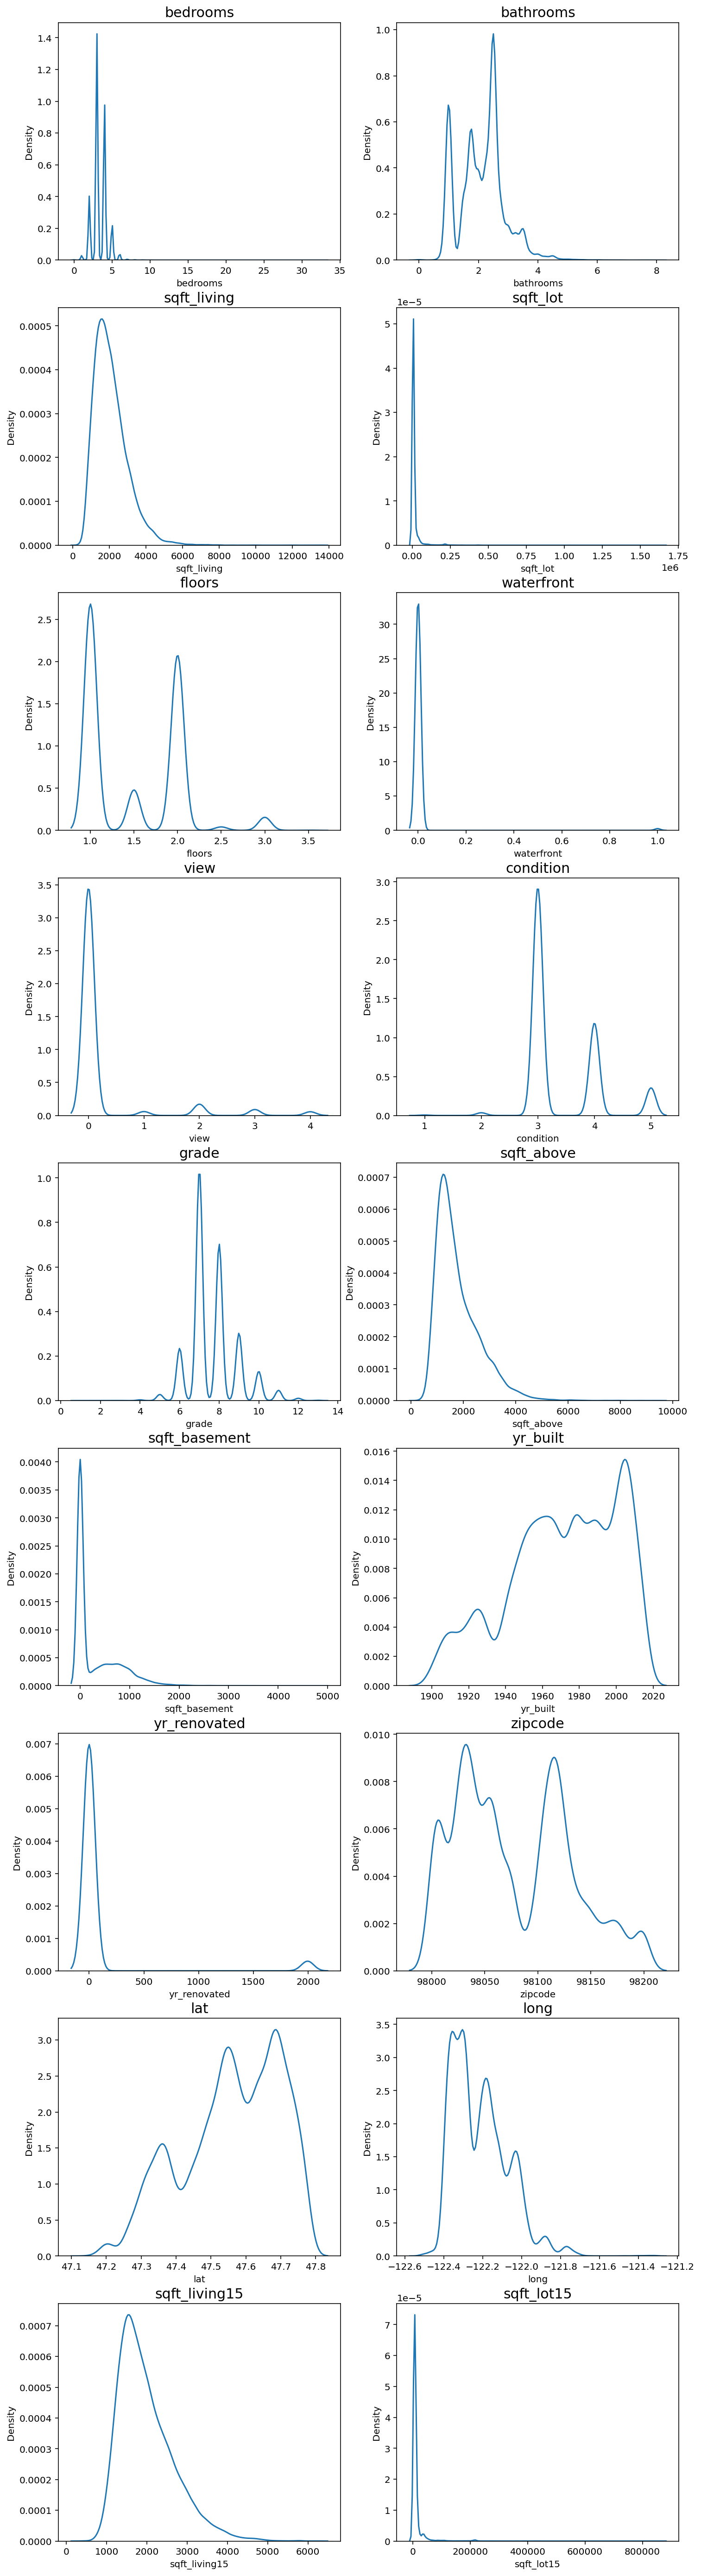

In [16]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

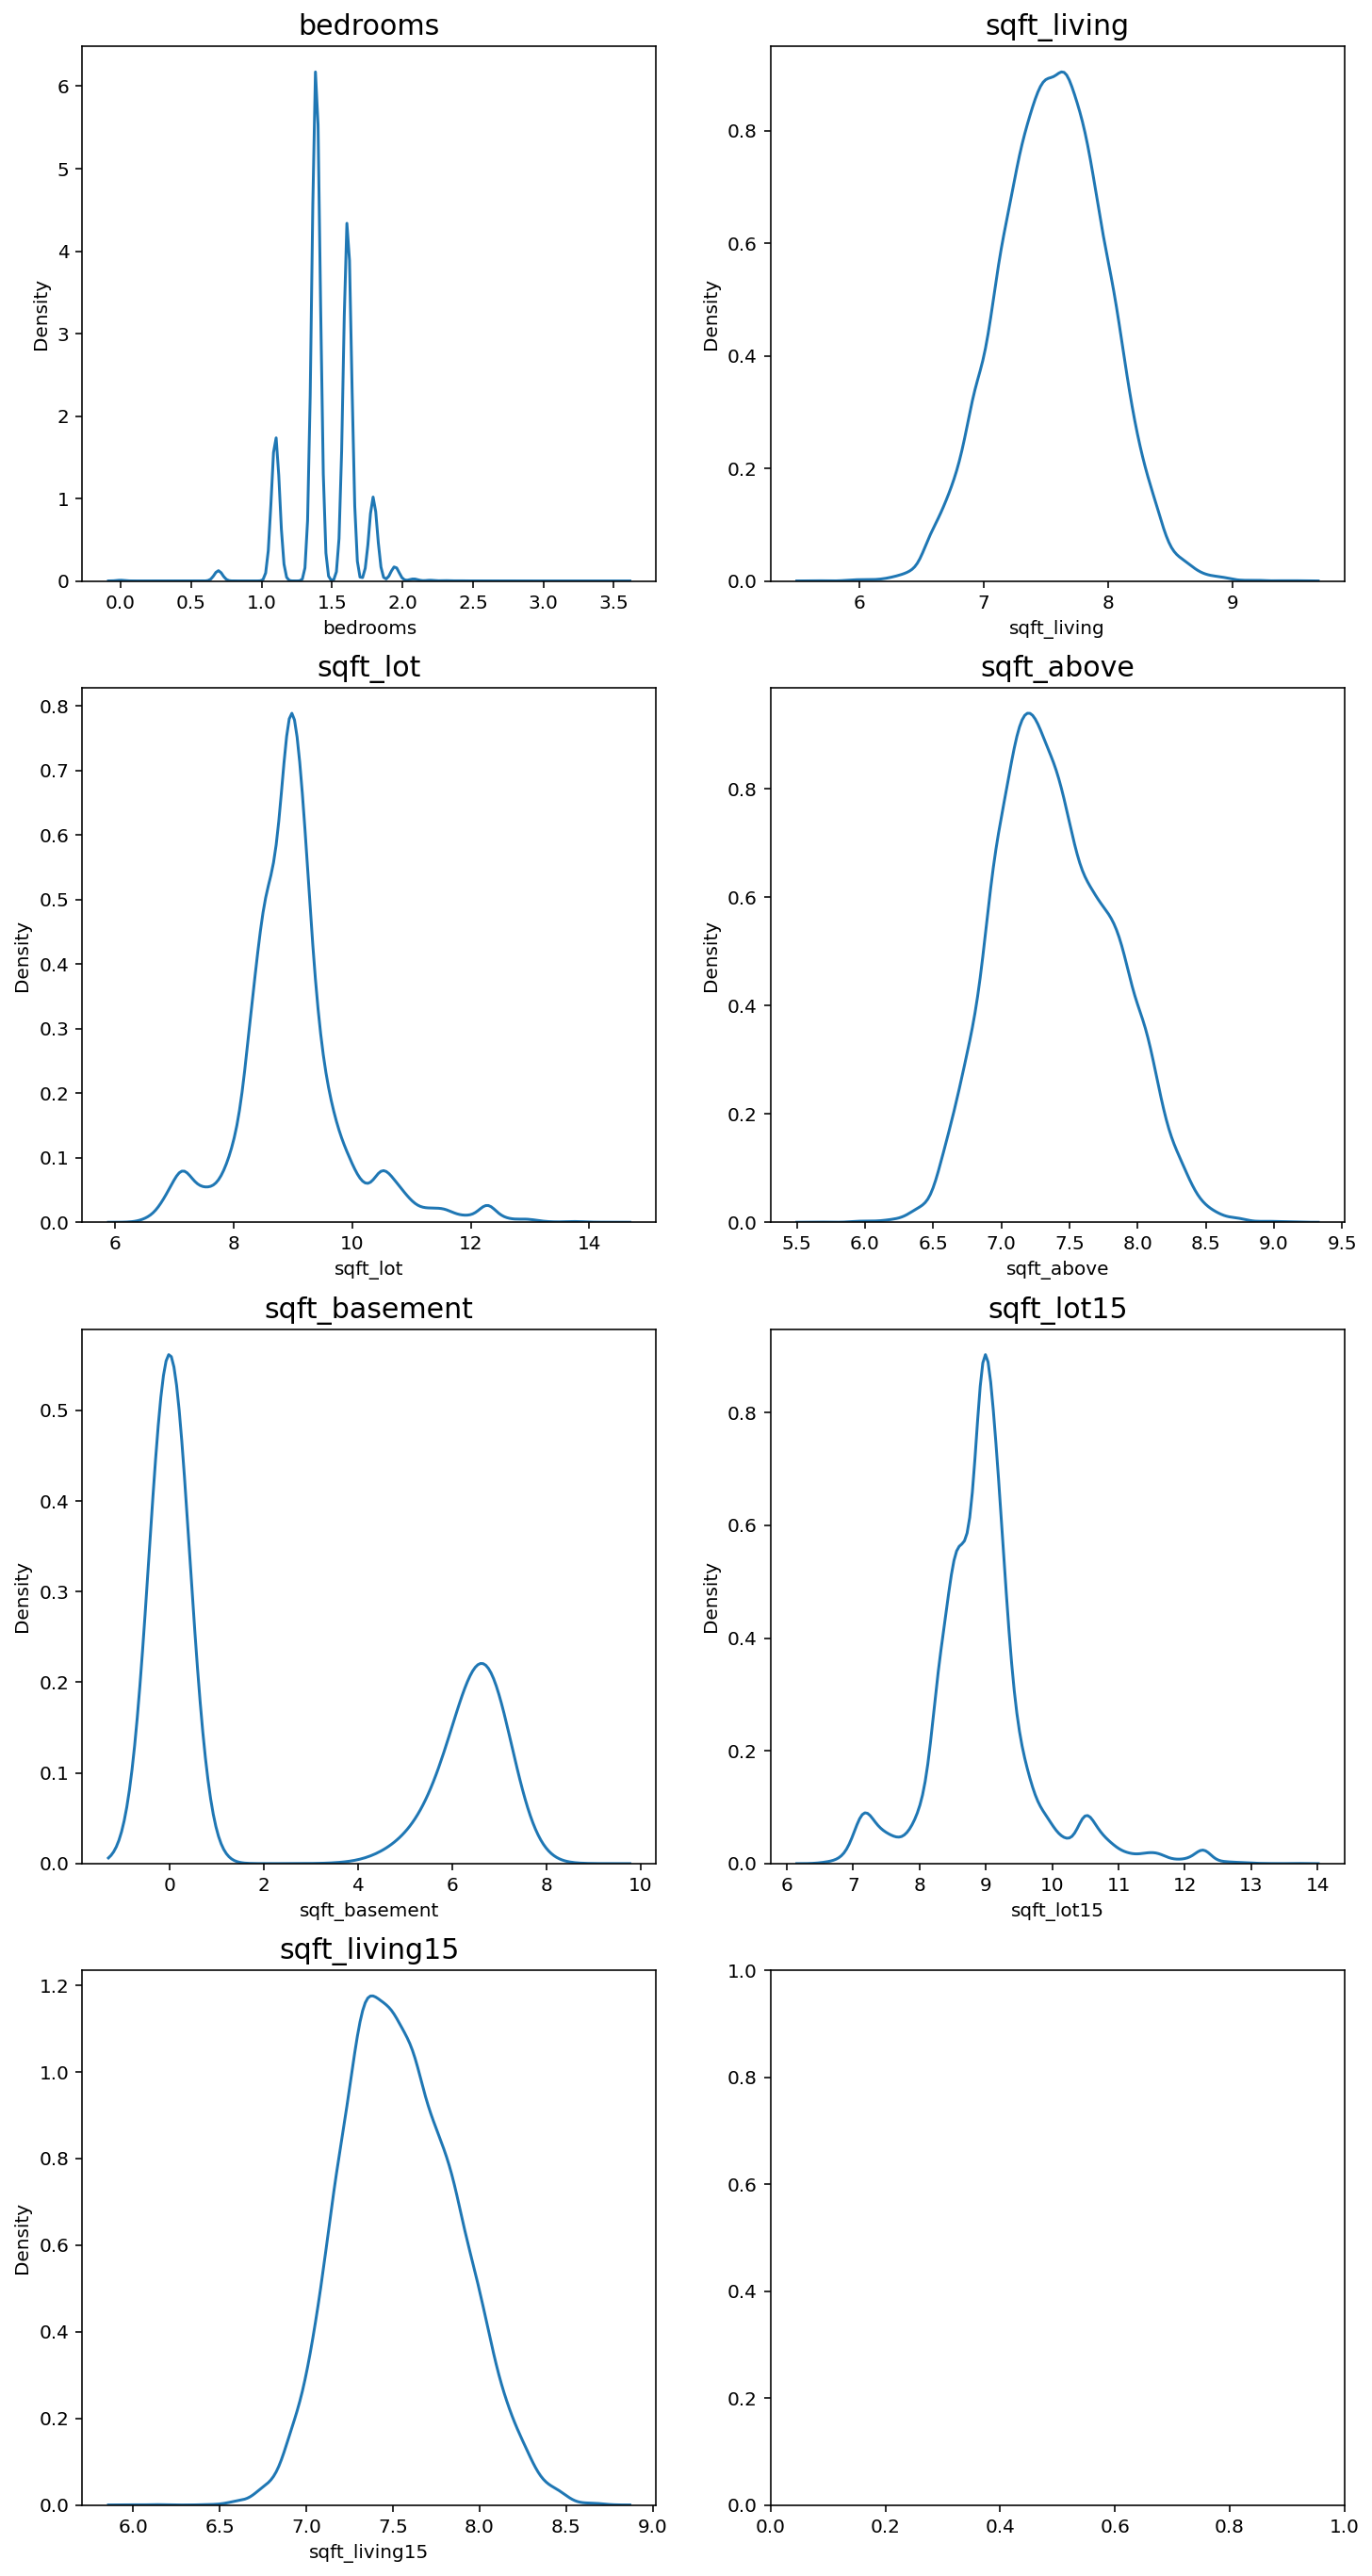

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [19]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [20]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [21]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [22]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [23]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [24]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [25]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()


my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


### Score: 116132.53138 로 결과가 나왔다.

----------------------------------------------------------------------------------------------------------------------

# 내 입맛대로 데이터를 준비해봅시다.


이제 랭킹을 올려봅시다. 아직 우리는 모델을 하나도 건드려보지 않았어요. 전처리도 제대로 하지 않았고요.


이번엔 주도적으로 데이터를 다뤄봅시다. 처음으로 다시 돌아가서! 데이터를 가져와봅시다.

In [26]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [27]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [28]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [29]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [30]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [31]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [32]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

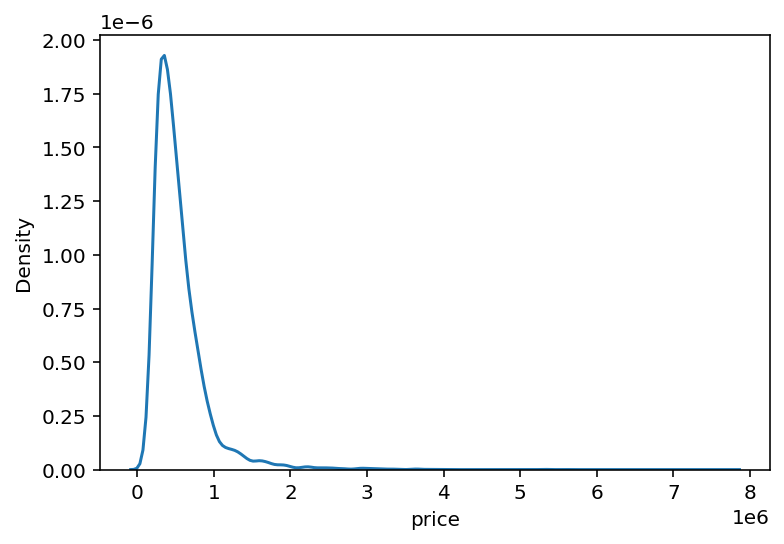

In [33]:
sns.kdeplot(y)
plt.show()

In [34]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

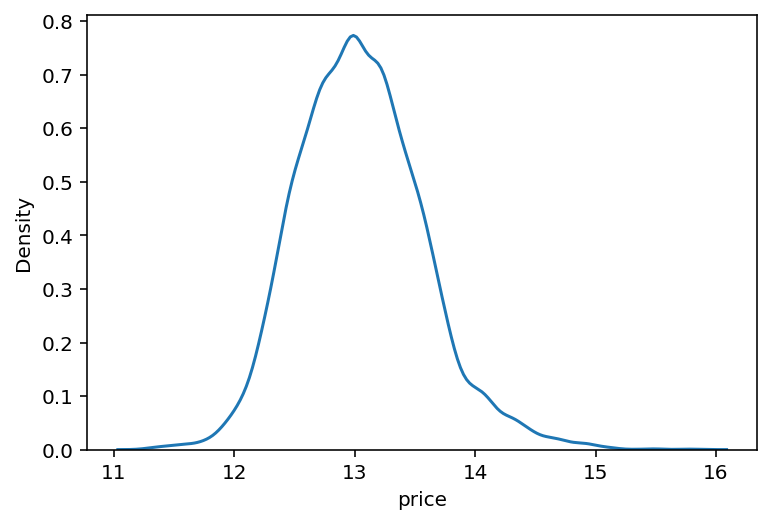

In [35]:
sns.kdeplot(y)
plt.show()

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [37]:
##반복되는 작업들을 쉽게 할 함수를 만든다. 사이킷런에 내장되어있는 mean_square_error로 가져와 RMSE 계산##

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [38]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [39]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [40]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [41]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [42]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [43]:
## 하이퍼 파라미터도 튜닝을 해봅시다. 그리드 탐색! ##

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [44]:
model = LGBMRegressor(random_state=random_state)


In [45]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [46]:
grid_model.cv_results_

{'mean_fit_time': array([0.47804484, 0.66427889, 1.07133274, 1.71174664]),
 'std_fit_time': array([0.09829044, 0.10619401, 0.15460229, 0.27132767]),
 'mean_score_time': array([0.04748874, 0.06412282, 0.06002216, 0.06613822]),
 'std_score_time': array([0.01564422, 0.01419386, 0.01153254, 0.03838721]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [47]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [48]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [49]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [50]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [51]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [52]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [53]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [54]:
## my_GridSearch 함수로 간단한 그리드 탐색 ##

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [55]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [56]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [57]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [58]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [59]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [60]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 이번에는 Score: 115807.04439 로 결과가 나왔다.

----------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------

#  프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

In [61]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 컬럼 확인, 전처리

In [62]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [63]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [65]:
def draw_kdeplot(column):

    plt.figure(figsize=[8,6])
    
    sns.kdeplot(train[column],bw=0.5,label='train')
    sns.kdeplot(test[column],bw=0.5,label='test')
    
    plt.xlabel(column,fontsize=12)
    plt.title(f"Distribution of {column}",fontsize=20)
    plt.show()

In [66]:
def make_count_df(df,column):
    dummy = df.copy()
    result_df = dummy[column].value_counts().sort_index().to_frame().reset_index().rename(columns={"index":column,column:"counts"})
    return result_df

In [67]:
def compare_categorical_ratio(count_train,count_test,column,adjust_x_annotate=5,fontsize=14):
    fig, ax = plt.subplots(1,2,figsize=[12,6])
    
    ax1 = plt.subplot(1,2,1)
    sns.barplot(x=column,y='counts',data=count_train,label='train')

    for p in ax1.patches:
        ax1.annotate('{:.2f}%'.format(p.get_height()/count_train["counts"].sum()) , (p.get_x()+p.get_width()/adjust_x_annotate, p.get_height()),fontsize=fontsize)

    ax2 = plt.subplot(1,2,2)
    sns.barplot(x=column,y='counts',data=count_test,label='test')

    for p in ax2.patches:
        ax2.annotate('{:.2f}%'.format(p.get_height()/count_test["counts"].sum()) , (p.get_x()+p.get_width()/adjust_x_annotate, p.get_height()),fontsize=fontsize)

    plt.suptitle(f"Comparing btw train and test about {column}")
    plt.show()

## Price (타겟 값인 가격의 분포 확인)


In [68]:
print("Minimum value of Price is {}, Maximum value of Price is {}".format(train.price.min(),train.price.max()))

Minimum value of Price is 78000.0, Maximum value of Price is 7700000.0


Text(0.5, 1.0, 'Distribution of Price value')

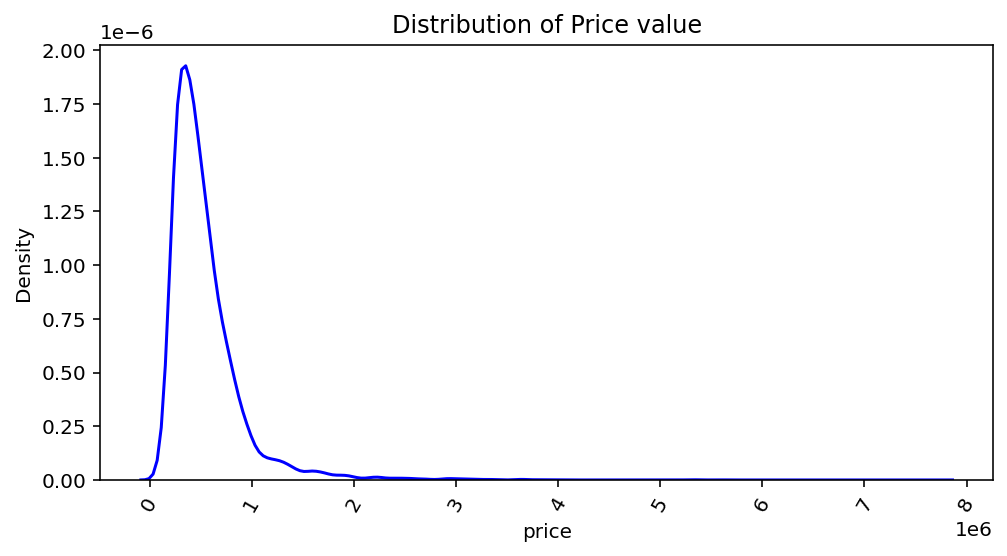

In [69]:
plt.figure(figsize=[8,4])
sns.distplot(train.price,hist=False,label='train',color='blue')
plt.xticks(rotation=60)
plt.title("Distribution of Price value")

##  Bathrooms, Bedrooms 

침실의 수와 화장실 수가 가격에 영향을 미치는 척도인지 확인한다.

In [70]:
train.bathrooms.value_counts().head()

2.50    3748
1.00    2675
1.75    2112
2.25    1433
2.00    1357
Name: bathrooms, dtype: int64

Text(0.5, 1.0, 'Distribution of Bathrooms(# of Bathrooms / # of Bedrooms)')

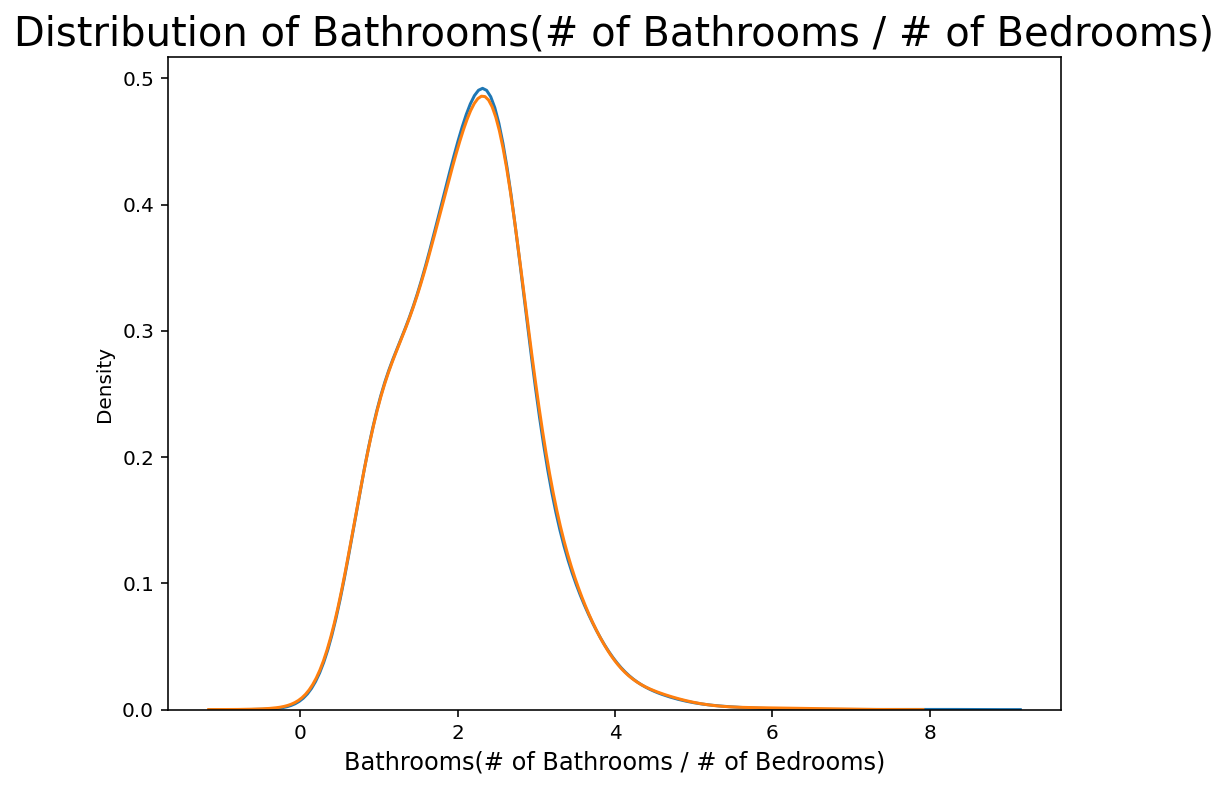

In [71]:
plt.figure(figsize=[8,6])

sns.kdeplot(train.bathrooms,bw=0.5,label='train')
sns.kdeplot(test.bathrooms,bw=0.5,label='test')

plt.xlabel("Bathrooms(# of Bathrooms / # of Bedrooms)",fontsize=12)
plt.title("Distribution of Bathrooms(# of Bathrooms / # of Bedrooms)",fontsize=20)

In [72]:
train.bedrooms.value_counts().sort_index()

0        4
1      133
2     1931
3     6835
4     4797
5     1108
6      188
7       22
8       10
9        5
10       2
Name: bedrooms, dtype: int64

In [73]:
bedroom_train = make_count_df(train,"bedrooms")
bedroom_test = make_count_df(test,"bedrooms")

Text(0.5, 1.0, 'Number of Bedrooms')

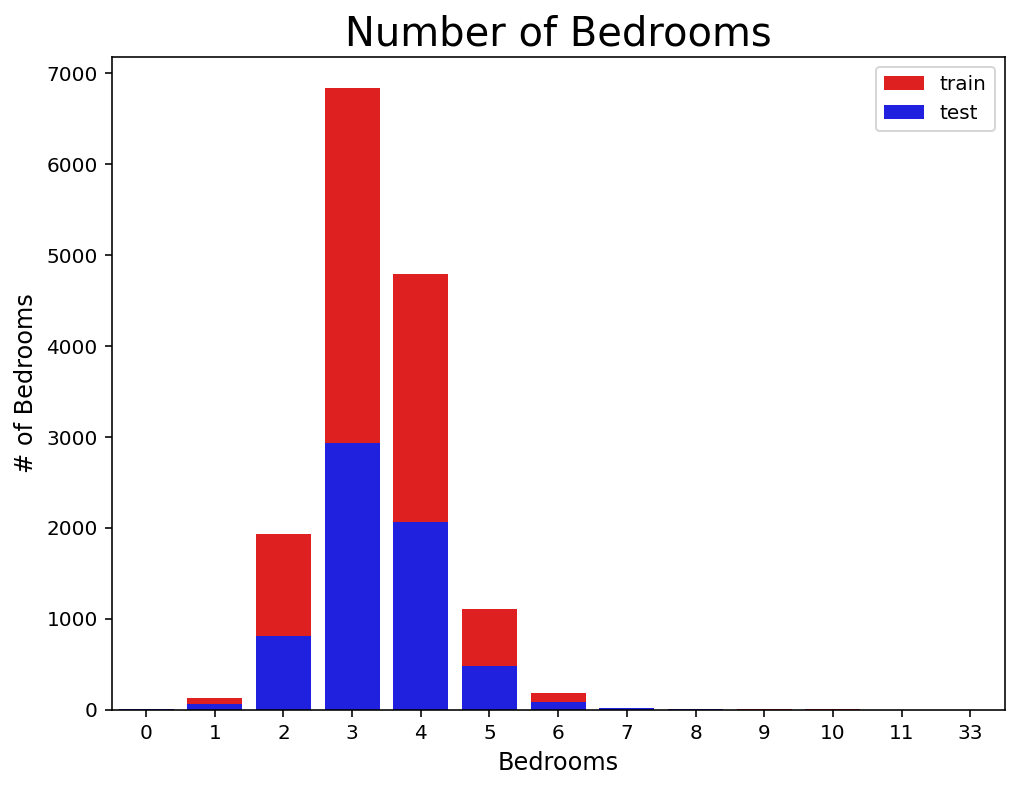

In [74]:
plt.figure(figsize=[8,6])

sns.barplot(x='bedrooms',y='counts',data=bedroom_train,label='train',color='red')
sns.barplot(x='bedrooms',y='counts',data=bedroom_test,label='test',color='blue')
plt.legend()
plt.ylabel("# of Bedrooms",fontsize=12)
plt.xlabel("Bedrooms",fontsize=12)

plt.title("Number of Bedrooms",fontsize=20)

In [75]:
train.bathrooms.mul(train.bedrooms).head()

0    3.00
1    2.00
2    6.00
3    6.75
4    4.50
dtype: float64

In [76]:
print("The min number of real bathroom is {}, max number of real bathroom is {}".format(train.bathrooms.mul(train.bedrooms).min(),train.bathrooms.mul(train.bedrooms).max()))

The min number of real bathroom is 0.0, max number of real bathroom is 67.5


# Sqft_living, Sqft_lot
주거공간의 면적과 주거공간을 포함한 차고, 마당 등의 공간이 포함된 면적의 분포를 확인해본다.

Text(0.5, 0.98, 'Distribution of sqft_living and sqft_lot')

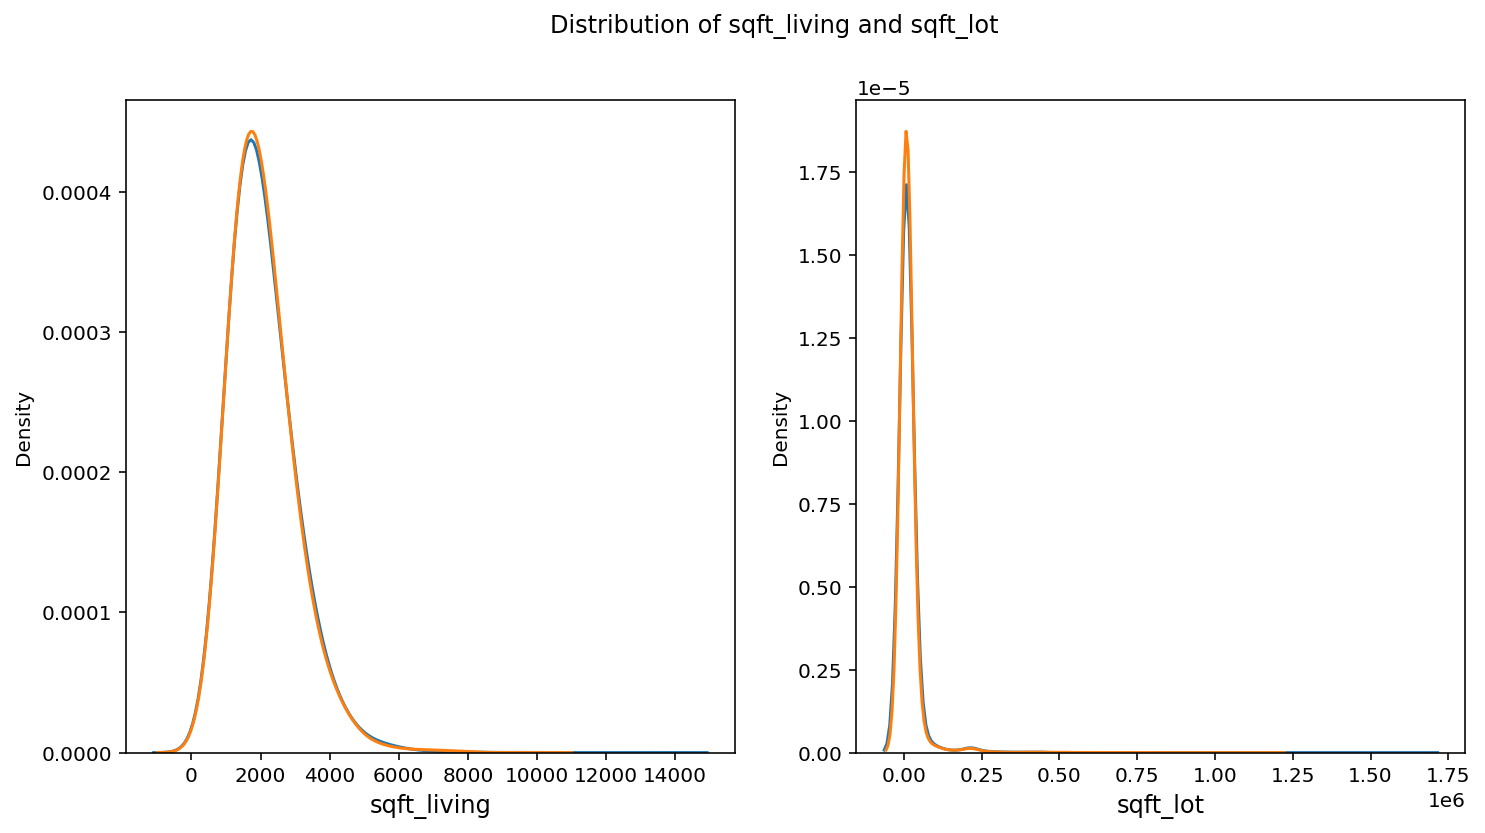

In [77]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.sqft_living,bw=0.5,label="train")
sns.kdeplot(test.sqft_living,bw=0.5,label='test')
ax1.set_xlabel("sqft_living",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.sqft_lot,bw=0.5,label="train")
sns.kdeplot(test.sqft_lot,bw=0.5,label='test')
ax2.set_xlabel("sqft_lot",fontsize=12)

plt.suptitle("Distribution of sqft_living and sqft_lot")

# Floor(층수)

In [78]:
train.floors.value_counts()


1.0    7361
2.0    5810
1.5    1330
3.0     417
2.5     113
3.5       4
Name: floors, dtype: int64

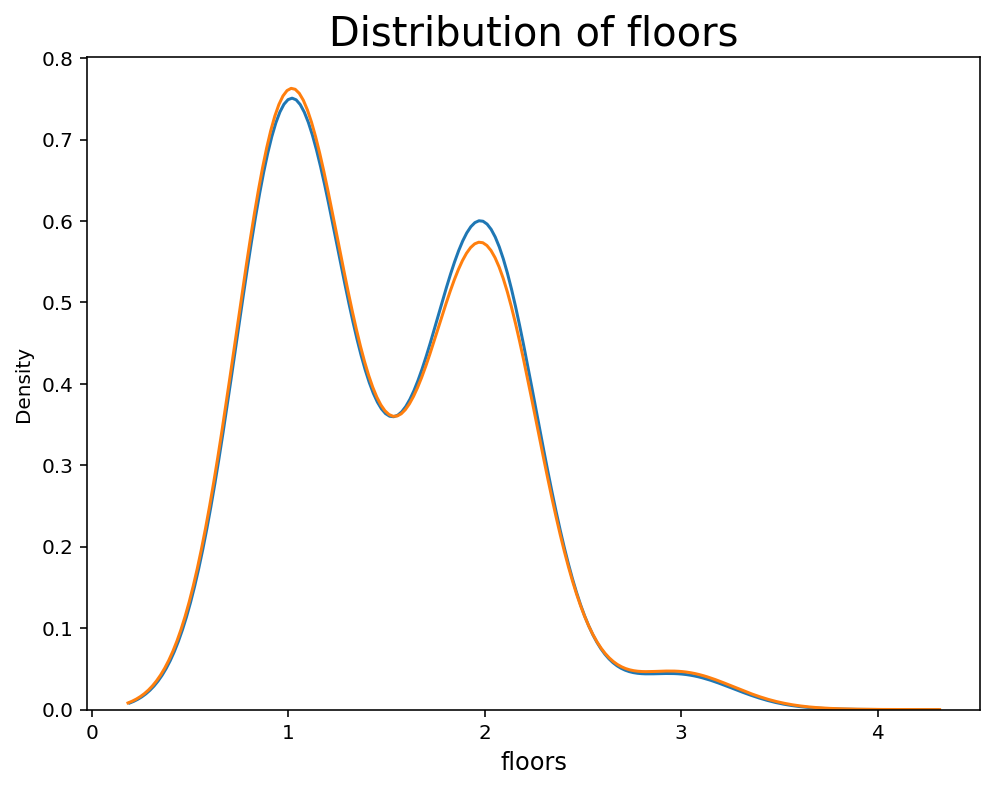

In [79]:
draw_kdeplot("floors")

# View 

In [80]:
train.view.value_counts().sort_index()

0    13548
1      241
2      665
3      373
4      208
Name: view, dtype: int64

In [81]:
view_train= make_count_df(train,"view")
view_test = make_count_df(test,"view")

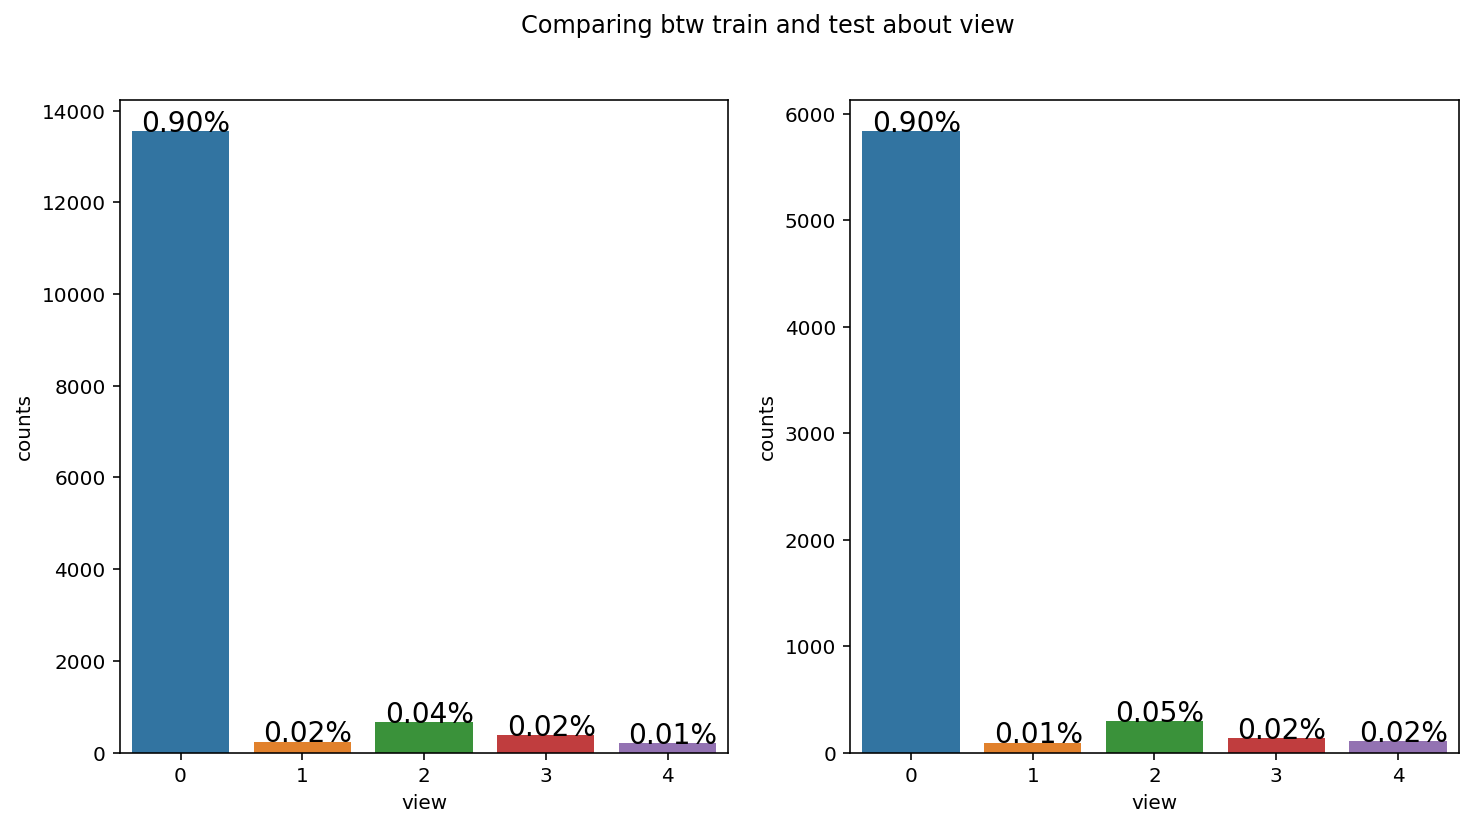

In [82]:
compare_categorical_ratio(view_train,view_test,"view",10)


# WaterFront (집 근처 강이 있는지)

In [83]:
waterfront_train = make_count_df(train,"waterfront")
waterfront_test = make_count_df(test,"waterfront")

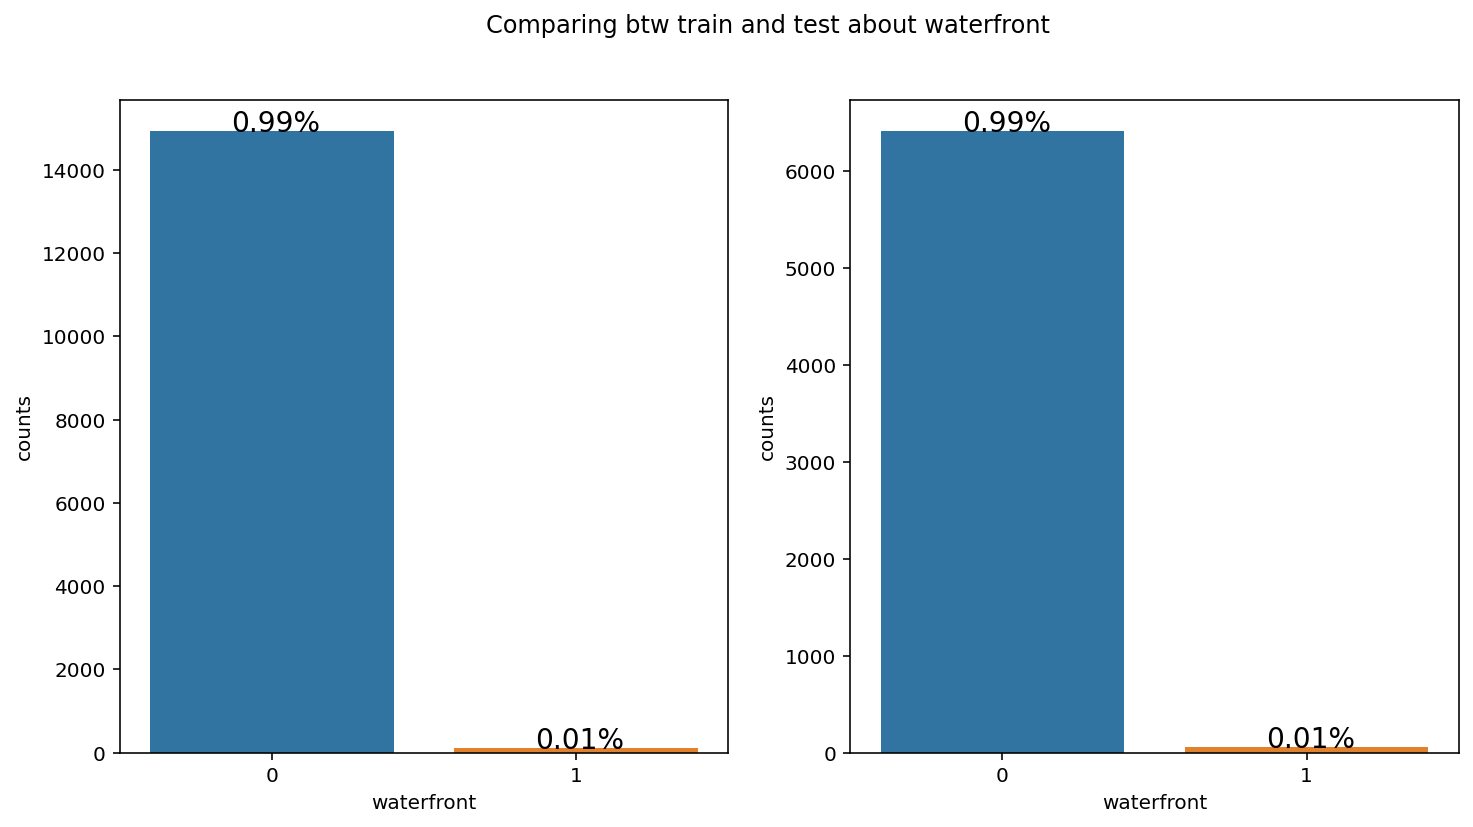

In [84]:
compare_categorical_ratio(waterfront_train,waterfront_test,"waterfront",3)

# Date

In [85]:
train.date.head(10)

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
5    20150403T000000
6    20140527T000000
7    20140528T000000
8    20141007T000000
9    20150312T000000
Name: date, dtype: object

In [86]:
train.date.apply(lambda x:str(x)[-7:]).value_counts()

T000000    15035
Name: date, dtype: int64

# Condition

In [87]:
condition_train = make_count_df(train,"condition")
condition_test = make_count_df(test,"condition")

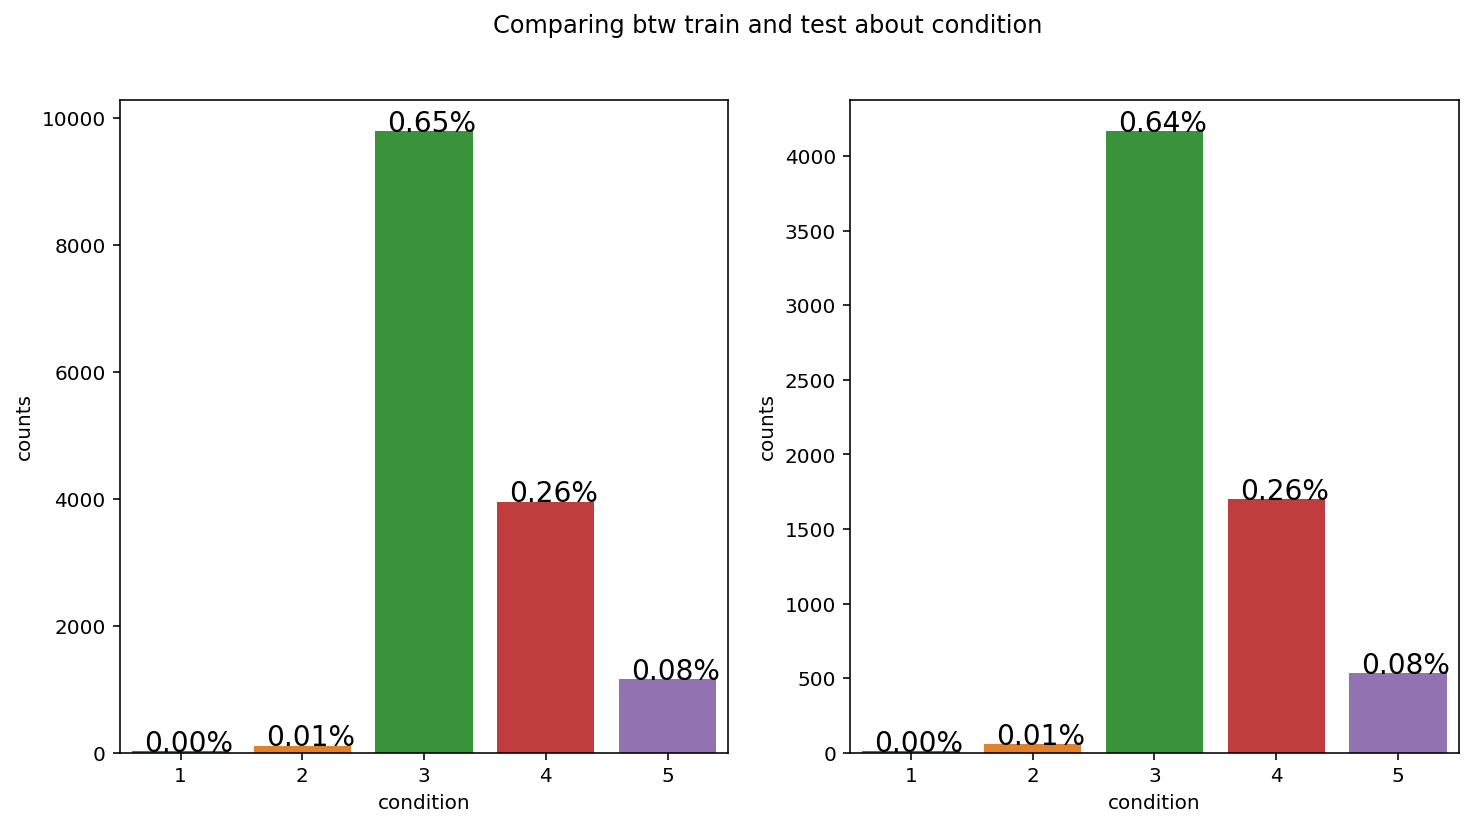

In [88]:
compare_categorical_ratio(condition_train,condition_test,"condition",8)

# Grade

In [89]:
grade_train = make_count_df(train,"grade") 
grade_test = make_count_df(test,"grade")

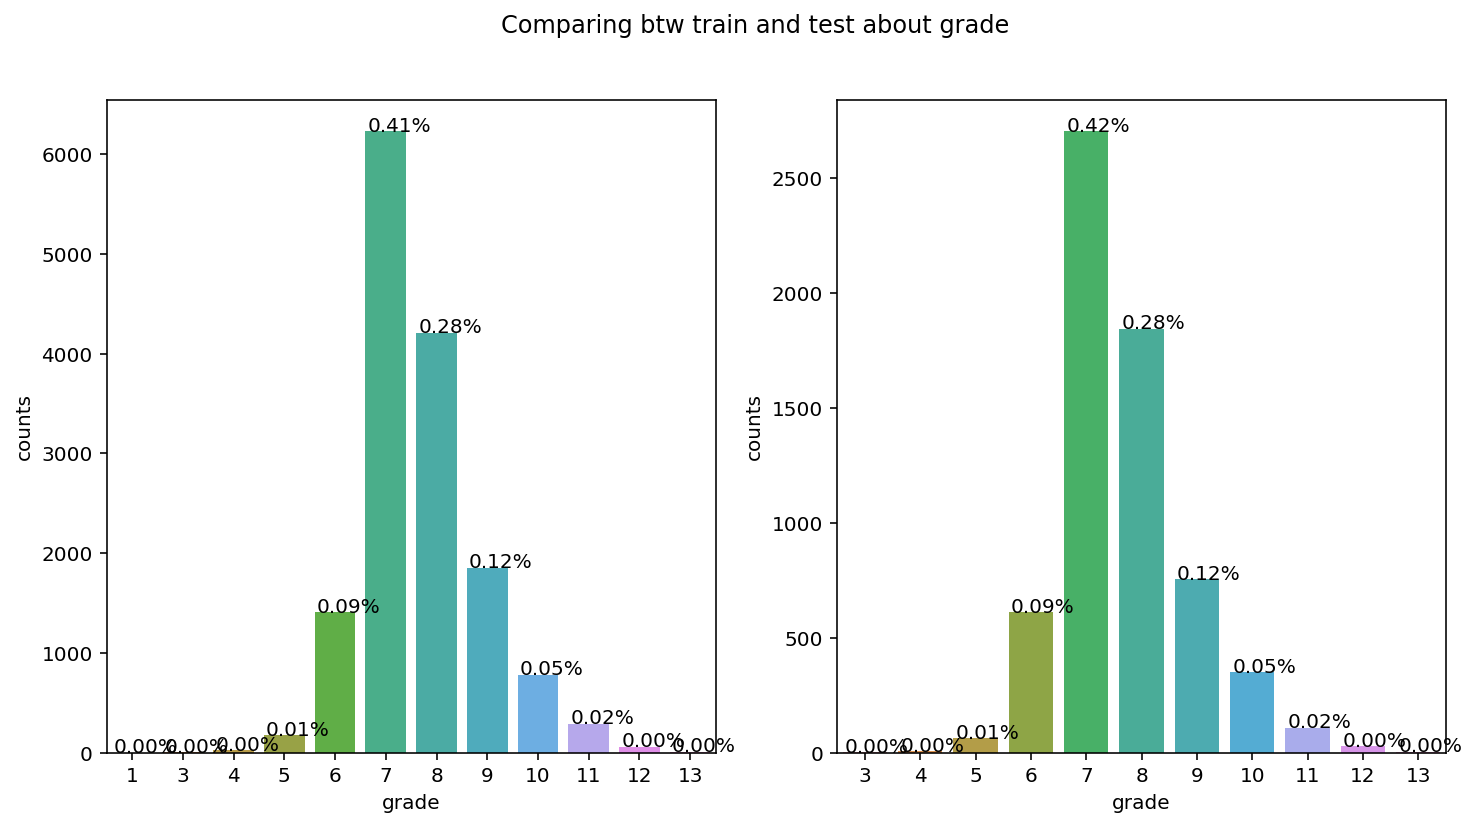

In [90]:
compare_categorical_ratio(grade_train,grade_test,"grade",adjust_x_annotate=20,fontsize=10)

# Sqft_above, Sqft_basement
지하를 제외한 평당면적과 지하실의 평당면적

Text(0.5, 0.98, 'Distribution of sqft_above and sqft_basement')

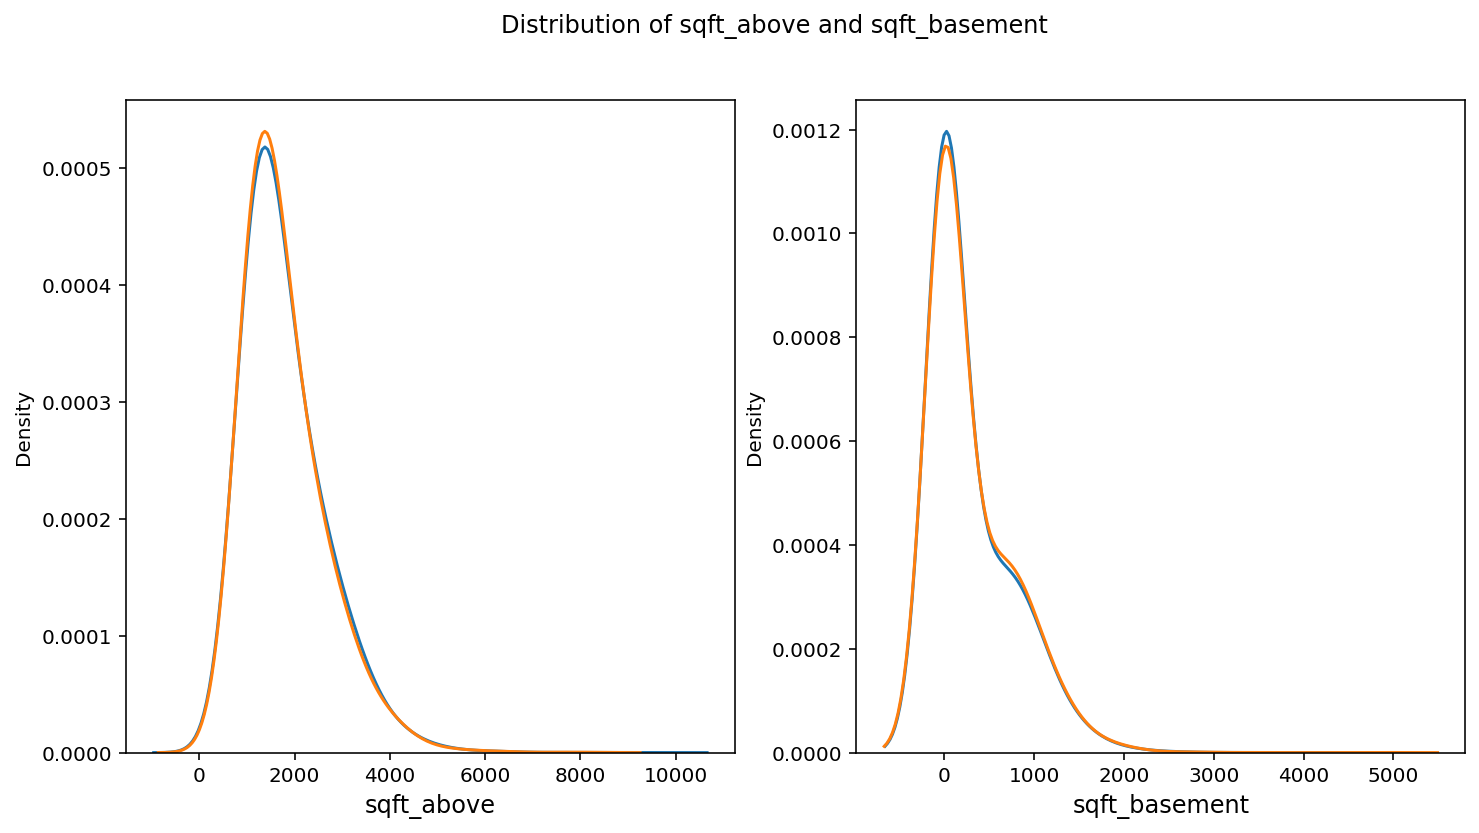

In [91]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.sqft_above,bw=0.5,label="train")
sns.kdeplot(test.sqft_above,bw=0.5,label='test')
ax1.set_xlabel("sqft_above",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.sqft_basement,bw=0.5,label="train")
sns.kdeplot(test.sqft_basement,bw=0.5,label='test')
ax2.set_xlabel("sqft_basement",fontsize=12)

plt.suptitle("Distribution of sqft_above and sqft_basement")

In [92]:
print("Ratio of 0 in sqft_basement of train_set {:.2f}% among {}".format(sum(train.sqft_basement==0)/len(train)*100,len(train)))
print("Ratio of 0 in sqft_basement of test_set {:.2f}% among {}".format(sum(test.sqft_basement==0)/len(test)*100,len(test)))

Ratio of 0 in sqft_basement of train_set 60.81% among 15035
Ratio of 0 in sqft_basement of test_set 60.50% among 6468


# Yr_bulit and Yr_renovate
집 지은 년도와 수리한 년도

Text(0.5, 0.98, 'Distribution of yr_built and yr_renovated')

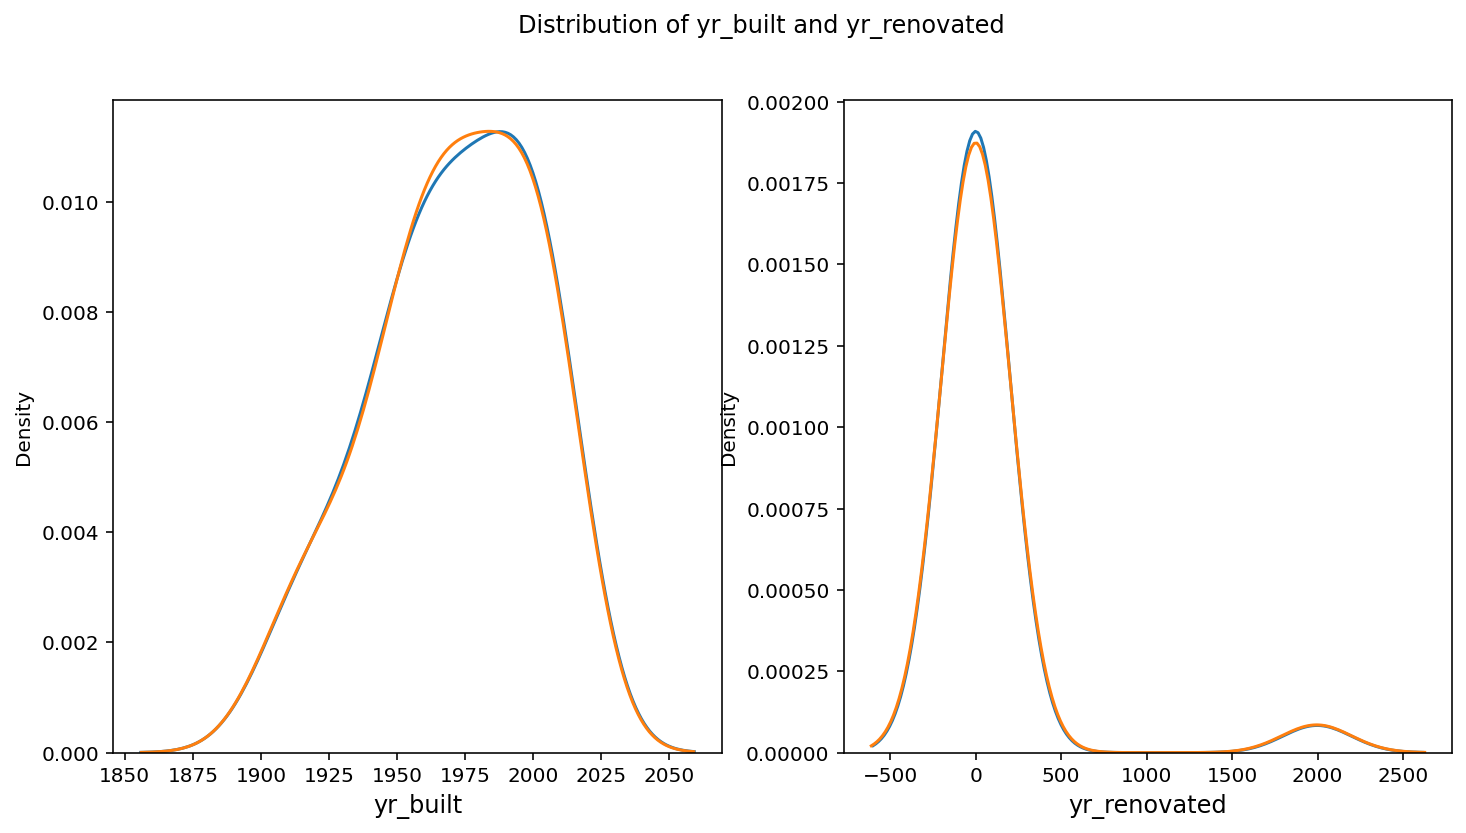

In [93]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.yr_built,bw=0.5,label="train")
sns.kdeplot(test.yr_built,bw=0.5,label='test')
ax1.set_xlabel("yr_built",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.yr_renovated,bw=0.5,label="train")
sns.kdeplot(test.yr_renovated,bw=0.5,label='test')
ax2.set_xlabel("yr_renovated",fontsize=12)

plt.suptitle("Distribution of yr_built and yr_renovated")

Text(0.5, 1.0, 'yr_renovated except for 0')

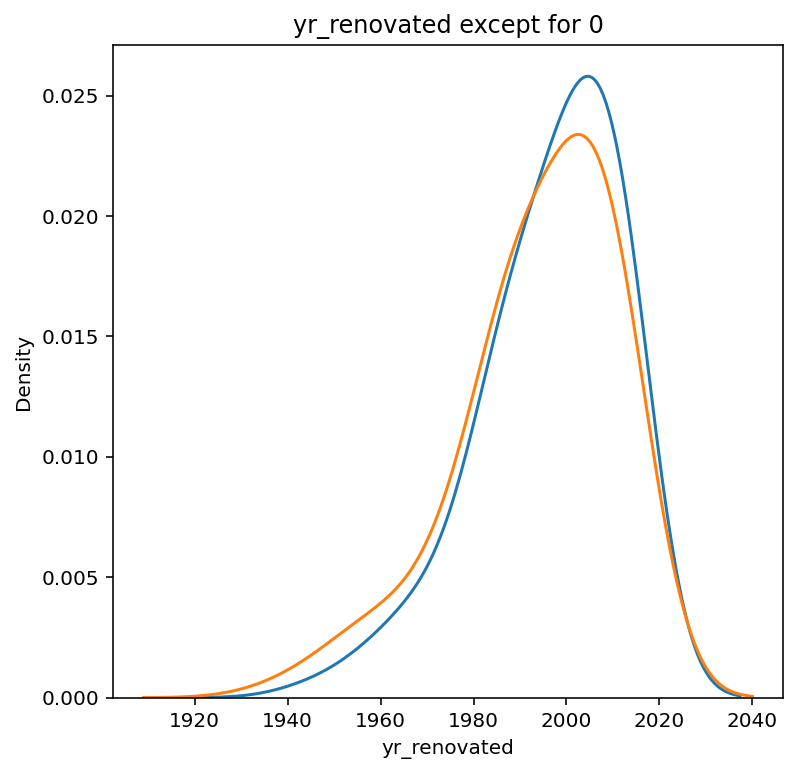

In [94]:
## 수리하지 않은 집을 제외하고 다시 분포를 만든다.

plt.figure(figsize=[6,6])

sns.kdeplot(train.loc[train["yr_renovated"]!= 0,"yr_renovated"],bw=0.5,label="train")
sns.kdeplot(test.loc[test["yr_renovated"]!= 0,"yr_renovated"],bw=0.5,label="test")
plt.xlabel("yr_renovated")
plt.title("yr_renovated except for 0")

In [95]:
print("Ratio of 0 in yr_renovated of train_set {:.2f}% among {}".format(sum(train.yr_renovated==0)/len(train)*100,len(train)))
print("Ratio of 0 in yr_renovated of test_set {:.2f}% among {}".format(sum(test.yr_renovated==0)/len(test)*100,len(test)))

Ratio of 0 in yr_renovated of train_set 95.80% among 15035
Ratio of 0 in yr_renovated of test_set 95.64% among 6468


# Zipcode (우편번호)

In [96]:
train.zipcode.head()

0    98178
1    98028
2    98074
3    98003
4    98198
Name: zipcode, dtype: int64

In [97]:
## 우편번호 다섯 숫자를 따르지 않는 예외 찾기

str(train.zipcode[0])

'98178'

In [98]:
import re

re1='(\\d{5})'
rg = re.compile(re1)

dummy_train = train.zipcode.apply(lambda x :rg.search(str(x)))
dummy_test = test.zipcode.apply(lambda x :rg.search(str(x)))

In [99]:
print("The number of unexpected form about zipcode of train_set {}".format(sum(dummy_train == 0)))
print("The number of unexpected form about zipcode of test_set {}".format(sum(dummy_test == 0)))

The number of unexpected form about zipcode of train_set 0
The number of unexpected form about zipcode of test_set 0


# lat and lon(위도와 경도)

Text(0.5, 1.0, 'Distribution of lat and long about train and test set')

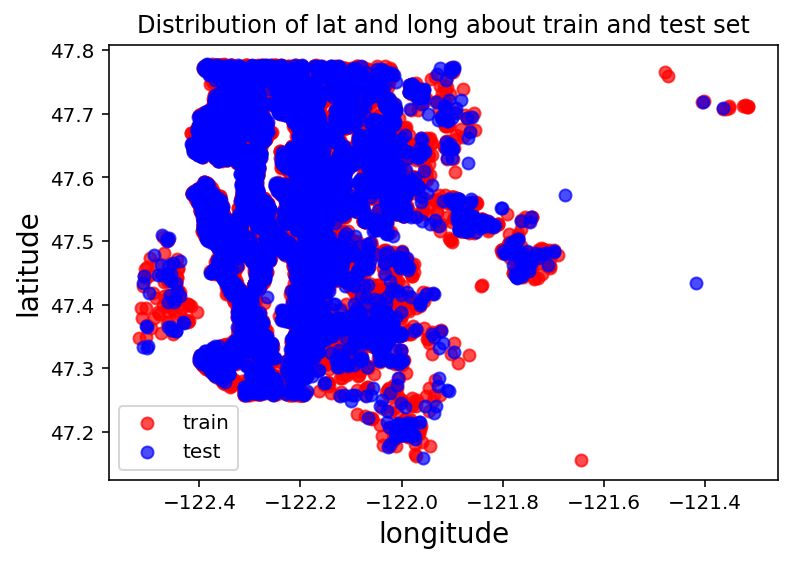

In [100]:
plt.scatter(x=train.long,y=train.lat,color='red',label='train',alpha=0.7)
plt.scatter(x=test.long,y=test.lat,color='blue',label='test',alpha=0.7)
plt.legend()
plt.xlabel("longitude",fontsize=14)
plt.ylabel("latitude",fontsize=14)
plt.title("Distribution of lat and long about train and test set")

Text(0.5, 0.98, 'Longitude and Latitude Distribution of train_set')

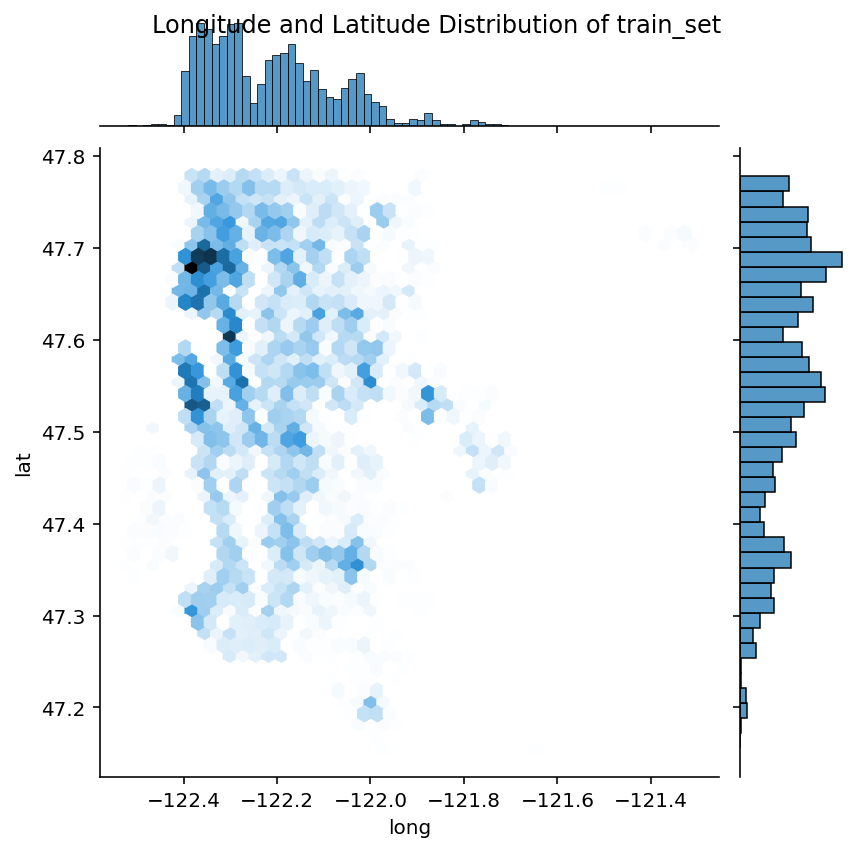

In [101]:
sns.jointplot(x='long',y='lat',data=train,kind="hex")
plt.suptitle("Longitude and Latitude Distribution of train_set")

Text(0.5, 0.98, 'Longitude and Latitude Distribution of test_set')

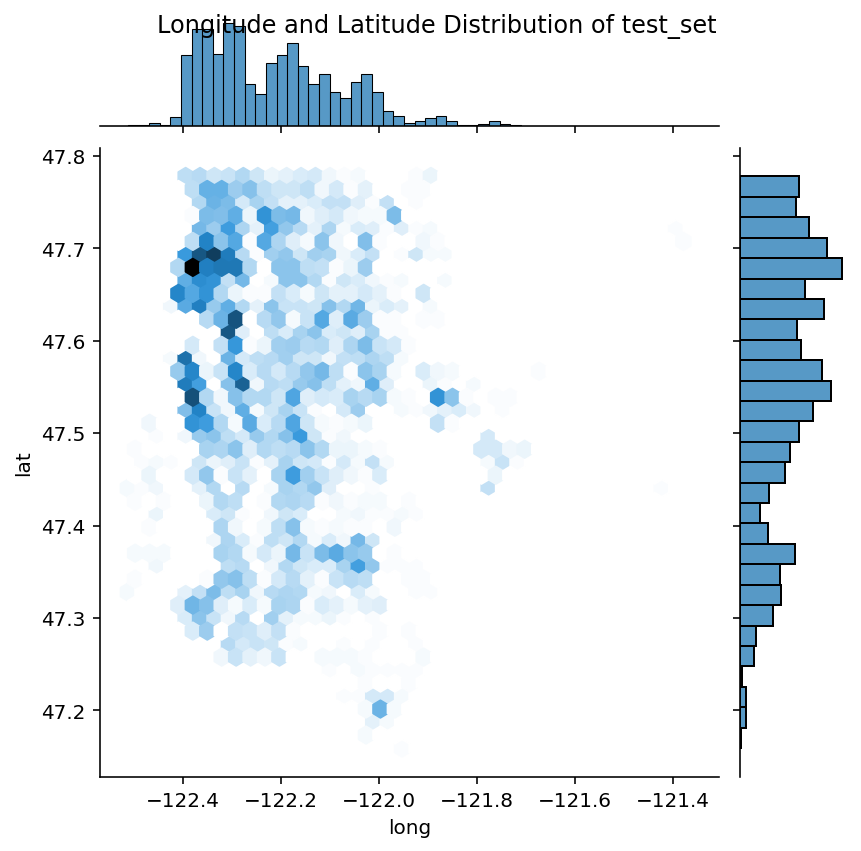

In [102]:
sns.jointplot(x='long',y='lat',data=test,kind="hex")
plt.suptitle("Longitude and Latitude Distribution of test_set")

## 치우친 칼럼들을 아래와 같이 정리했다.

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15

In [103]:
skewed_cols = ["bedrooms","sqft_living","sqft_lot","sqft_above","sqft_basement","sqft_living15","sqft_lot15"]

In [104]:
def to_logarithm(df,cols):
    
    result_df = df.copy()
    
    for col in cols:
        result_df[col] = np.log1p(result_df[col])
        
    return result_df

In [105]:
## 로그화 작업

log_train = to_logarithm(train,skewed_cols)
log_test = to_logarithm(test,skewed_cols)

In [106]:
def making_additional_cols(df):
    
    result_df = df.copy()
    
    result_df['date'] = result_df['date'].apply(lambda e: e.split('T')[0])
    result_df['yr_renovated'] = result_df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    result_df['renovated'] = result_df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    result_df['yr_renovated'] = result_df['yr_renovated'].fillna(result_df['yr_built'])
    result_df['renovated'] = result_df['renovated'].fillna(0)
    result_df['yr_renovated'] = result_df['yr_renovated'].astype('int')
    
    result_df.loc[result_df.renovated > 0,'renovated']= 1.0
    
    result_df['total_rooms'] = result_df['bedrooms'] + result_df['bathrooms']
    result_df['sqft_ratio'] = result_df['sqft_living'] / result_df['sqft_lot']
    result_df['sqft_total_size'] = result_df['sqft_above'] + result_df['sqft_basement']
    result_df['sqft_ratio_1'] = result_df['sqft_living'] / result_df['sqft_total_size']
    result_df['sqft_ratio15'] = result_df['sqft_living15'] / result_df['sqft_lot15']
    
    result_df["year"] = pd.to_numeric(result_df.date.apply(lambda x:x[:4]))
    result_df["month"] = pd.to_numeric(result_df.date.apply(lambda x:x[4:6]))
    result_df.drop("date",axis=1,inplace=True)
    
    return result_df

In [107]:
adj_log_train = making_additional_cols(log_train)
adj_log_test = making_additional_cols(log_test)

In [108]:
adj_log_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,renovated,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,year,month
0,0,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,...,7.201171,8.639588,0.0,2.386294,0.818803,7.074117,1.0,0.833509,2014,10
1,1,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,...,7.908755,8.995041,0.0,2.098612,0.721756,6.647688,1.0,0.879235,2015,2
2,2,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,...,7.496097,8.923191,0.0,3.386294,0.825489,7.427144,1.0,0.840069,2015,2
3,3,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,...,7.713785,8.827615,0.0,3.636294,0.843688,7.447751,1.0,0.873824,2014,6
4,4,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,...,7.409136,9.181118,0.0,2.886294,0.758837,6.966967,1.0,0.806997,2015,1


In [109]:
adj_log_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,renovated,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,year,month
0,0,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,...,7.201171,8.639588,0.0,2.386294,0.818803,7.074117,1.0,0.833509,2014,10
1,1,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,...,7.908755,8.995041,0.0,2.098612,0.721756,6.647688,1.0,0.879235,2015,2
2,2,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,...,7.496097,8.923191,0.0,3.386294,0.825489,7.427144,1.0,0.840069,2015,2
3,3,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,...,7.713785,8.827615,0.0,3.636294,0.843688,7.447751,1.0,0.873824,2014,6
4,4,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,...,7.409136,9.181118,0.0,2.886294,0.758837,6.966967,1.0,0.806997,2015,1


In [110]:
adj_log_train["price"] = np.log1p(adj_log_train["price"])

# Model

In [111]:
X_adj_log_train = adj_log_train[adj_log_train.columns.values[2:]]
y_adj_log_train = adj_log_train["price"]
X_adj_log_test = adj_log_test[adj_log_test.columns.values[1:]]

predictions_dict = dict()
scores_dict = dict()

In [112]:
## XGBRegressor

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error

# price를 로그화 하기 전에 사용했던 xgboost평가 함수
def xgb_rmse(preds,dtrain):
    
    labels = dtrain.get_label()
    
    score = np.sqrt(mean_squared_error(labels,preds))
  
    return "xgb_rmse",score

# 로그화된 price를 사용하는 xgboost평가 함수
def log_xgb_rmse(preds,dtrain):
    
    labels = dtrain.get_label()
    
    score = np.sqrt(mean_squared_error(np.expm1(labels),np.expm1(preds)))
  
    return "xgb_rmse",score

# xgboost 실행 함수
def model_xgb(X_train,y_train,X_test,nfolds=5,hyperparameters=None,logarithm=False):
    
    feature_names = X_train.columns.values
    
    valid_scores = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    valid_scores_list = []
    
    importances = np.zeros(len(feature_names))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df["features"] = feature_names
    
    if hyperparameters:
        params = hyperparameters
      
    else:
        params = {
            'base_score': 0.5,
             'booster': 'gbtree',
             'colsample_bylevel': 1,
             'colsample_bytree': 1,
             'gamma': 0,
             'importance_type': 'gain',
             'learning_rate': 0.1,
             'max_delta_step': 0,
             'max_depth': 3,
             'min_child_weight': 1,
             'missing': None,
             'n_estimators': 100,
             'n_jobs': 1,
             'nthread': None,
             'objective': 'reg:linear',
             'random_state': 101,
             'reg_alpha': 0,
             'reg_lambda': 1,
             'scale_pos_weight': 1,
             'seed': None,
             'silent': True,
             'subsample': 1}
    
    xgbr = xgb.XGBRegressor(**params)
    
    if logarithm:
        fold = KFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = log_xgb_rmse
    else:
        fold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = xgb_rmse
    
    print(params)
    
    for i,(train_indices,valid_indices) in enumerate(fold.split(X_train.values,y_train.values)):
        
        X = X_train.loc[train_indices]
        y = y_train.loc[train_indices]
        X_valid = X_train.loc[valid_indices]
        y_valid = y_train.loc[valid_indices]
        
        print("{} fold processing".format(i+1),"#"*20)
        
        xgbr.fit(X,y,eval_metric=log_xgb_rmse,verbose=500,early_stopping_rounds=250,eval_set=[(X,y),(X_valid,y_valid)])
  
        valid_scores_list.append(xgbr.get_booster().best_score)
        
        feature_importance_df[f"{i+1}"] = xgbr.feature_importances_
        
        if logarithm:
            valid_score = np.expm1(xgbr.predict(X_valid))
            prediction = np.expm1(xgbr.predict(X_test))
        
        else:
            valid_score = xgbr.predict(X_valid)
            prediction = xgbr.predict(X_test)
        
        valid_scores[valid_indices] += valid_score
        predictions += prediction / nfolds
    
    valid_mean_score = np.mean(valid_scores_list)
    
    print(f"mean_valid_score is {valid_mean_score} at {nfolds}")
    
    feature_importance_df["mean"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    feature_importance_df["std"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    
    fi_sorted = feature_importance_df.sort_values("mean",ascending=False)
    
    plt.figure(figsize=[6,40])
    sns.barplot(x="mean",y="features",data=fi_sorted,xerr=fi_sorted["std"])
    plt.title("Feature Importances of xgboost",fontsize=12)
    plt.show()
        
        
    return valid_mean_score, predictions

In [113]:
tuned_params = {
    'alpha': 0.23381888633529596,
    'booster': 'gbtree',
    'colsample_bytree': 0.5833187080443007,
    'gamma': 0.11877149186475625,
    'lambda': 0.7815712086648032,
    'learning_rate': 0.060873580474025094,
    'max_depth': 7,
    'min_child_weight': 5,
    'n_estimators': 3000, #1046
    'objective': 'reg:linear',
    'random_state': 101,
    'subsample': 0.6307967933325185}

{'alpha': 0.23381888633529596, 'booster': 'gbtree', 'colsample_bytree': 0.5833187080443007, 'gamma': 0.11877149186475625, 'lambda': 0.7815712086648032, 'learning_rate': 0.060873580474025094, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 3000, 'objective': 'reg:linear', 'random_state': 101, 'subsample': 0.6307967933325185}
1 fold processing ####################
[13:37:53] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.79492	validation_0-xgb_rmse:653620.81250	validation_1-rmse:11.79941	validation_1-xgb_rmse:665508.00000
[500]	validation_0-rmse:0.11364	validation_0-xgb_rmse:75897.77344	validation_1-rmse:0.15975	validation_1-xgb_rmse:109438.83594
[1000]	validation_0-rmse:0.10669	validation_0-xgb_rmse:71100.29688	validation_1-rmse:0.15931	validation_1-xgb_rmse:108440.65625
[1500]	validation_0-rmse:0.10369	validation_0-xgb_rmse:68990.28125	validation_1-rmse:0.15909	validation_1-xgb_rmse:107543.5781

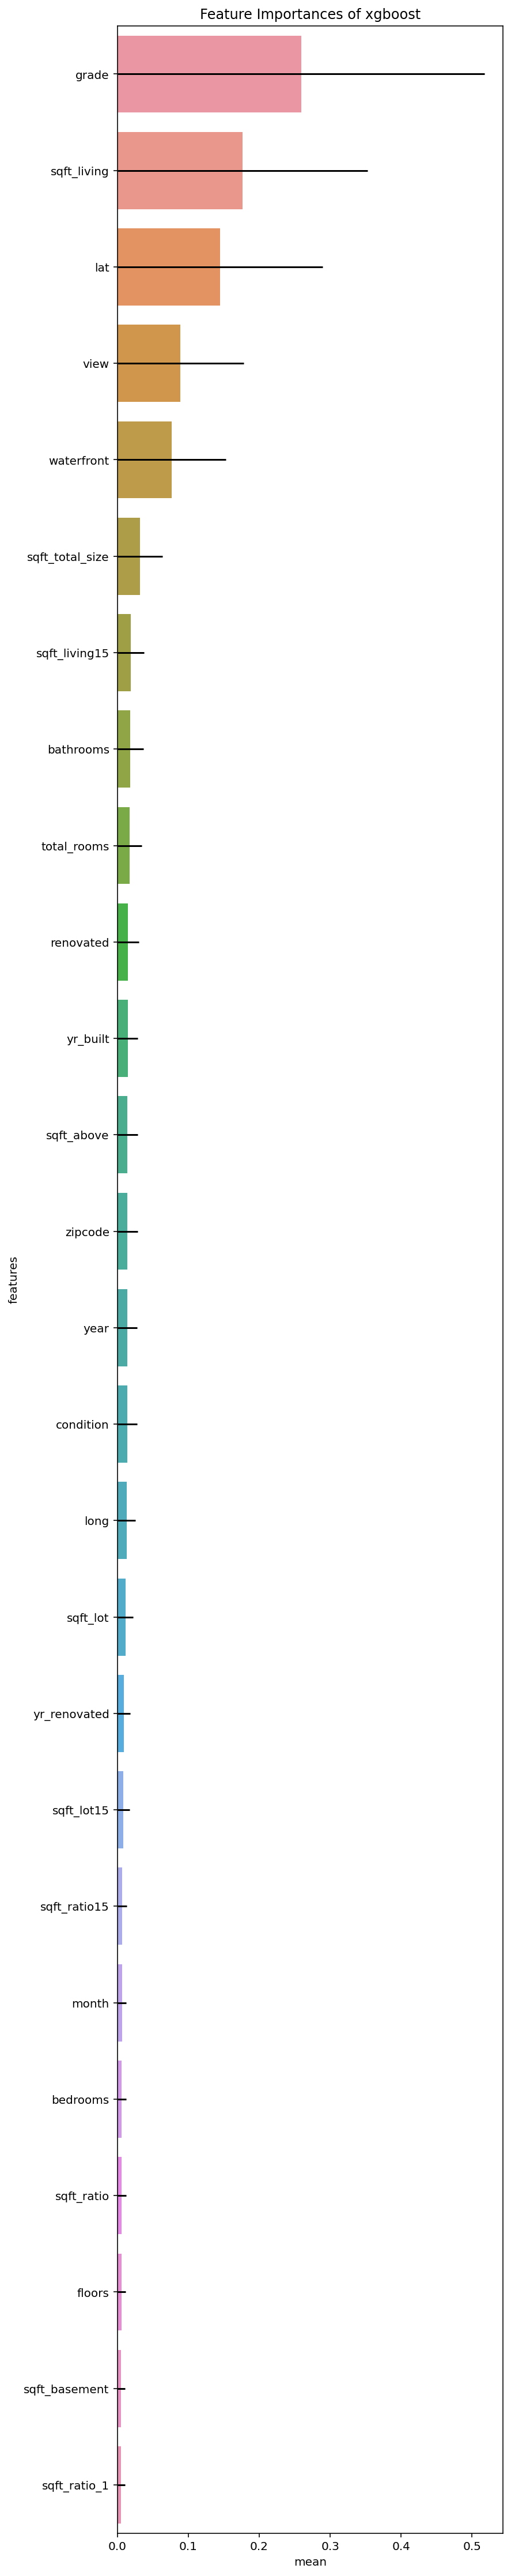

In [114]:
valid_score,predictions = model_xgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True)

In [115]:
target = "xgb_uni_5"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission["price"] = predictions
submission.to_csv("xgb_uni_layer_5.csv",index=False)

# LGBMRegressor

In [116]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error

# price를 로그화 하기 전에 사용했던 lighgbm평가 함수
def lgb_rmse(y,preds):
    
    score = np.sqrt(mean_squared_error(y,preds))
  
    return "lgb_rmse",score,False

# price를 로그화 한 후에 사용하는 lightgbm평가 함수
def log_lgb_rmse(y,preds):
    
    score = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(preds)))
  
    return "lgb_rmse",score,False

# lightgbm 실행함수
def model_lgb(X_train,y_train,X_test,nfolds=5,hyperparameters=None,logarithm=False):
    
    feature_names = X_train.columns.values
    
    valid_scores = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    valid_scores_list = []
    
    importances = np.zeros(len(feature_names))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df["features"] = feature_names
    
    if hyperparameters:
        params = hyperparameters
      
    else:
        params = {'boosting_type': 'gbdt',
                 'class_weight': None,
                 'colsample_bytree': 1.0,
                 'importance_type': 'split',
                 'learning_rate': 0.1,
                 'max_depth': -1,
                 'min_child_samples': 20,
                 'min_child_weight': 0.001,
                 'min_split_gain': 0.0,
                 'n_estimators': 1000,
                 'n_jobs': -1,
                 'num_leaves': 31,
                 'objective': "rmse",
                 'random_state': 101,
                 'reg_alpha': 0.0,
                 'reg_lambda': 0.0,
                 'silent': True,
                 'subsample': 1.0,
                 'subsample_for_bin': 200000,
                 'subsample_freq': 0}
    
    lgbr = lgb.LGBMRegressor(**params)
    
    if logarithm:
        fold = KFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = log_lgb_rmse
    else:
        fold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = lgb_rmse
    
    print(params)
    
    for i,(train_indices,valid_indices) in enumerate(fold.split(X_train.values,y_train.values)):
        
        X = X_train.values[train_indices]
        y = y_train.values[train_indices]
        X_valid = X_train.values[valid_indices]
        y_valid = y_train.values[valid_indices]
        
        print("{} fold processing".format(i+1),"#"*20)
        
        lgbr.fit(X,y,eval_set=[(X,y),(X_valid,y_valid)],eval_names=["train","valid"],eval_metric=e_metric,verbose=500,early_stopping_rounds=250)
        
        valid_scores_list.append(lgbr.best_score_["valid"]["lgb_rmse"])

        feature_importance_df[f"{i+1}"] = lgbr.feature_importances_
        
        if logarithm:
            valid_score = np.expm1(lgbr.predict(X_valid))
            prediction = np.expm1(lgbr.predict(X_test))
        
        else:
            valid_score = lgbr.predict(X_valid)
            prediction = lgbr.predict(X_test)
        
        valid_scores[valid_indices] += valid_score
        predictions += prediction / nfolds
        
    valid_mean_score = np.mean(valid_scores_list)
    
    print(f"mean_valid_score is {valid_mean_score} at {nfolds}")
    
    feature_importance_df["mean"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    feature_importance_df["std"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    
    fi_sorted = feature_importance_df.sort_values("mean",ascending=False)
    
    plt.figure(figsize=[6,40])
    sns.barplot(x="mean",y="features",data=fi_sorted,xerr=fi_sorted["std"])
    plt.title("Feature Importances of lightgbm",fontsize=12)
    plt.show()
        
    return valid_mean_score, predictions

In [117]:
tuned_params = {
    'boosting_type': 'gbrt',
    'class_weight': None,
    'colsample_bytree': 0.8424667117862588,
    'learning_rate': 0.11657835160316778,
    'max_depth': 21,
    'min_child_samples': 30,
    'min_child_weight': 2.7488547729054593,
    'n_estimators': 2160, #1080
    'num_leaves': 9,
    'objective': 'regression',
    'random_state': 101,
    'reg_alpha': 0.6915673059398951,
    'reg_lambda': 0.6362045095817355,
    'subsample': 0.8931910384738333,
    'subsample_for_bin': 100000,
    'subsample_freq': 4}

{'boosting_type': 'gbrt', 'class_weight': None, 'colsample_bytree': 0.8424667117862588, 'learning_rate': 0.11657835160316778, 'max_depth': 21, 'min_child_samples': 30, 'min_child_weight': 2.7488547729054593, 'n_estimators': 2160, 'num_leaves': 9, 'objective': 'regression', 'random_state': 101, 'reg_alpha': 0.6915673059398951, 'reg_lambda': 0.6362045095817355, 'subsample': 0.8931910384738333, 'subsample_for_bin': 100000, 'subsample_freq': 4}
1 fold processing ####################
[500]	train's l2: 0.0168612	train's lgb_rmse: 89449.7	valid's l2: 0.0267924	valid's lgb_rmse: 122435
[1000]	train's l2: 0.0124085	train's lgb_rmse: 75048.1	valid's l2: 0.0262306	valid's lgb_rmse: 119227
2 fold processing ####################
[500]	train's l2: 0.0170211	train's lgb_rmse: 89307.3	valid's l2: 0.0252524	valid's lgb_rmse: 127832
[1000]	train's l2: 0.0125204	train's lgb_rmse: 75782.5	valid's l2: 0.0251048	valid's lgb_rmse: 125530
3 fold processing ####################
[500]	train's l2: 0.0168431	trai

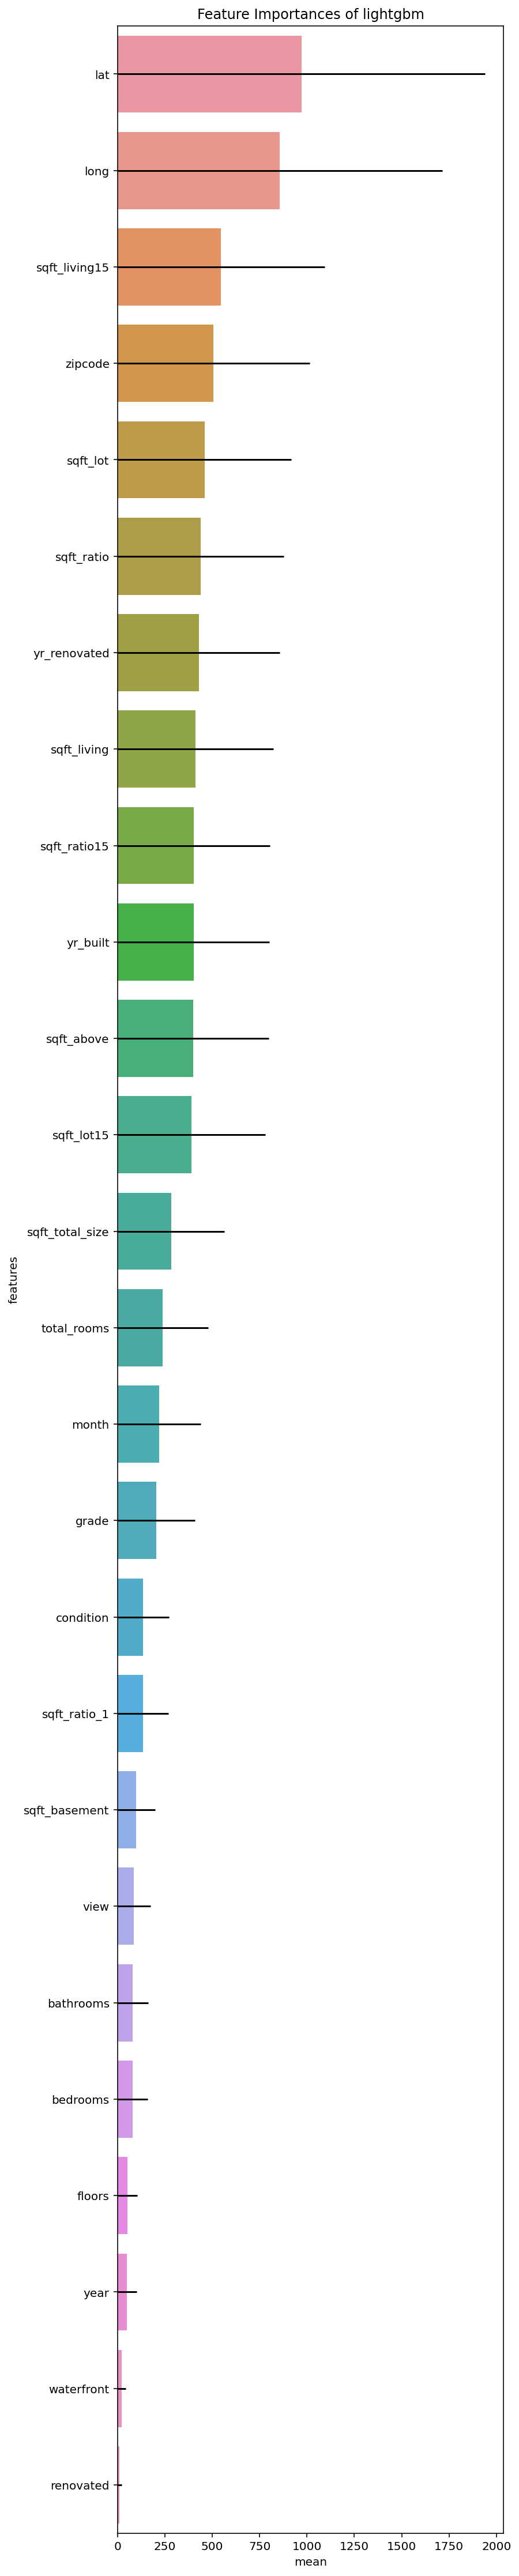

In [118]:
valid_score, predictions = model_lgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True)

In [119]:
target = "lgb_uni_5"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission["price"] = predictions
submission.to_csv("lgb_uni_layer_5.csv",index=False)

<AxesSubplot:xlabel='rmse_score', ylabel='model'>

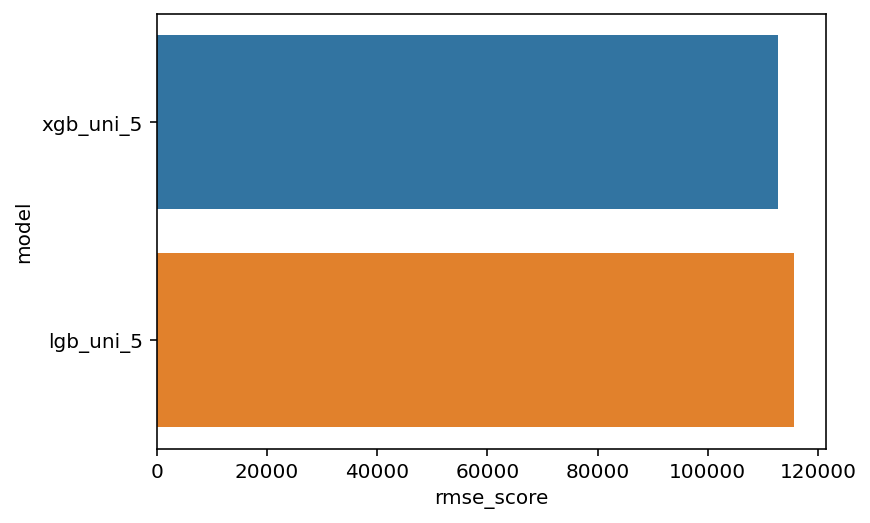

In [120]:
result_df = np.transpose(pd.DataFrame(scores_dict,index=range(1))).rename(columns={0:"rmse_score"}).sort_values(by="rmse_score")
result_df = result_df.reset_index().rename(columns={"index":"model"})
sns.barplot(x="rmse_score",y="model",data=result_df)

In [121]:
target1 = "xgb_uni_5"
target2 = "lgb_uni_5"

ensembled_predictions = predictions_dict[target1] * 0.5 + predictions_dict[target2] * 0.5
ensembled_score = scores_dict[target1] * 0.5 + scores_dict[target2] * 0.5

predictions_dict["ensemble1"] = ensembled_predictions
scores_dict["ensemble1"] = ensembled_score

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission["price"] = ensembled_predictions
submission.to_csv("xgb_lgb_ensemble.csv",index=False)

<AxesSubplot:xlabel='rmse_score', ylabel='model'>

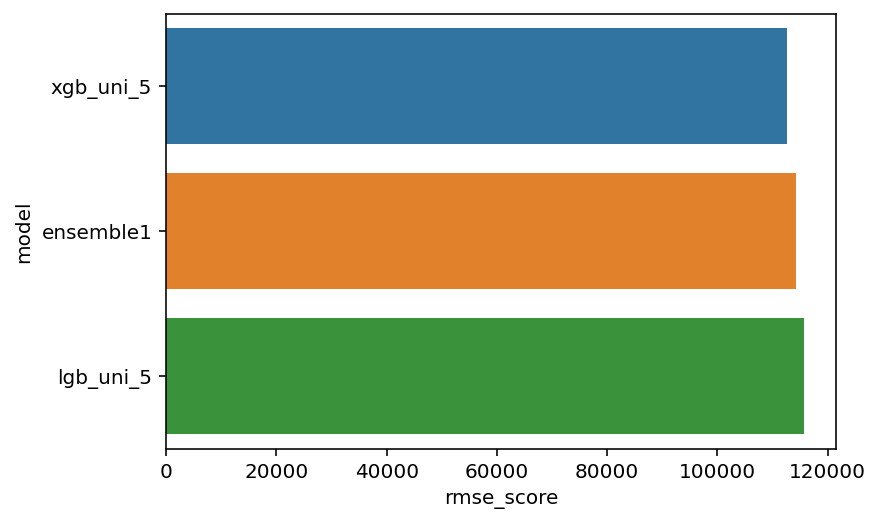

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END ...................

In [122]:
result_df = np.transpose(pd.DataFrame(scores_dict,index=range(1))).rename(columns={0:"rmse_score"}).sort_values(by="rmse_score")
result_df = result_df.reset_index().rename(columns={"index":"model"})
sns.barplot(x="rmse_score",y="model",data=result_df)

# 이번에는 Score: 105048.58582 로 결과가 나왔다.

----------------------------------------------------------------------------------------------------------------------

# 회고

데이터 전처리 과정, 최적의 모델링으로 RMSE 값 최소화하는 것을 목표로 했다.

처음부터 컬럼 하나하나를 분석하는 것도 쉽지 않았으며 어떤 데이터를 버려야하는지 판단하는 데에 어려움이 있었다. 즉, 데이터 전처리는 무척이나 중요하고 어려운 과정이였다. 최적의 성능을 내기 위해서는 모델링에 데이터를 잘 버리지 않으면 최적의 결과를 얻을 수 없기에 데이터 전처리는 중요하다고 생각한다. 

그리고 또한, 무조건적으로 한 기법이 성능이 좋다고 맹신하지 말아야겠다는 것을 배웠다. Lgbm이 당연히 성능이 더 뛰어나다 생각하였지만, XGB와 앙상블하는 것이 더 뛰어나가 판단했다. 

캐글을 처음 따라해보고 직접 시도해보면서 이미 시도했던 다양한 다른 사람들의 커널들을 보며 이 사람들이 왜, 어떤 생각으로 이 데이터는 뽑아냈으며, 이 데이터는 걸러냈는지 이해하려고 노력하게 되고 이들의 방식을 통해 새롭고 다양한 방법도 배우게 되었다. 나 스스로 컬럼들을 만들어내고 데이터 전처리를 하고 정제할 수 있는 능력을 키우는 것이 매우 중요하다고 느꼈다. 